<a id = "table-of-content"></a>
# Table of Content

- [Introduction](#intro)
- [Overview of analysis steps](#overview)
- [Read in the data](#read_data)
- [Step 0: constructin gamePlayId](#step0)
- [Step 1: Filtering tackle plays](#step1)
- [Step 2: Extract data from tackler and ballcarrier](#step2)
    - [Pivot the data from long to wide format](#pivot)
- [Step 3: Determining point of first contact](#Step3)
- [Step 4: Determining tackle time](#step4)
    - [Tackle by position](#tackleByPosition)
- [Step 5: Feature engineering](#FeatureEngineering)
    - [Summary Statistics of existing features](#sumamryStatistics)
    - [Convex Hull](ConvexHull)
    - [Distance over last n frames per play](#DistanceLastFrames)
    - [Variables from "players" and "plays"](#additionalVariables)
    - [Turning angle](#TurningAngle)
    - [Add features to collapsed tracking data](#AddFeatures)
    - [Add resonse to data](#AddResponse)
- [Step 6: Model](#model)
    - [Feature importance](#FeatureImportance)
    - [Extract most important features](#importantFeatures)
    - [Train GAM](#GAM)
- [Visualization](#Visualization)
    - [Plot football field](#footballField)
    - [Animate play](#animateField)
    - [Add predictions](#addPredictions)


# Introduction and Goal

This notebook contains all the code that was used for our submission to the NFL Big Data Bowl 2024 competition. 

In this notebook we aim to investigate the influence of various covariates on the tackle time of a football play. The tackling time is defined as the time passed between the moment of first contact and the tackle. The analyzed covariates include given variables from the provided data sets, as well as self-engineered ones.

We hope to provide insight on how the different analyzed features explain the expected tackle time, such that these can be used for future tackle time predicitons. 

<a id = "overview"></a>
# Overview of the analysis steps

1. All plays are filtered for those, that have a tackle event in them at any point
2. For all such plays, the tracking info of the ball carrier and the tackler need to be extracted
3. For all tackle games, the first contact times as well as the tackle times need to be determined
    * the point of first contact is determined using a regression model
4. Based on these two time points the tackle time can be calculated
5. Based on the tracking data, as well as the other available data sets, existing, as well as custom covariates are determined
6. Modelling. We chose to investigate initial feature importance using a Random Forest Regressor. For the main model we use a GAM

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os

# For creating the football filed
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
%matplotlib inline
! pip install pygam

<a id = "read_data"></a>
# Read in the data

In [2]:
#Your working directory
dir = "C:/Users/fabia/Documents/Uni/Big Data Bowl 2024/"

games = pd.read_csv(dir + "games.csv")
plays = pd.read_csv(dir + "plays.csv")
players = pd.read_csv(dir + "players.csv")
tackles = pd.read_csv(dir + "tackles.csv")

In [3]:
tracking_one = pd.read_csv(dir + "tracking_week_1.csv")
tracking_two = pd.read_csv(dir + "tracking_week_2.csv")
tracking_three = pd.read_csv(dir + "tracking_week_3.csv")
tracking_four = pd.read_csv(dir + "tracking_week_4.csv")
tracking_five = pd.read_csv(dir + "tracking_week_5.csv")
tracking_six = pd.read_csv(dir + "tracking_week_6.csv")
tracking_seven = pd.read_csv(dir + "tracking_week_7.csv")
tracking_eight = pd.read_csv(dir + "tracking_week_8.csv")
tracking_nine = pd.read_csv(dir + "tracking_week_9.csv")

In [4]:
# concatenate all tracking data sets to one big dataframe
tracking = pd.concat([tracking_one,tracking_two,tracking_three,tracking_four,tracking_five,tracking_six,tracking_seven,tracking_eight,tracking_nine])

<a id = "step0"></a>
# Step 0: Concatenate gameId and playId to a joined gamePlayId column in all relevant dataframes

The tracking, tackle and play data set contain columns for "gameId" and "playId". Together they uniquely identify a single play. We concatenate them together, such that it makes the search for a specific play easier later on.

In [5]:
# play dataframe
game_play_id = (plays["gameId"].astype(str) + plays["playId"].astype(str)).astype("int64")
plays.insert(loc=0, column='gamePlayId', value=game_play_id)

# tackle dataframe
game_play_id = (tackles["gameId"].astype(str) + tackles["playId"].astype(str)).astype("int64")
tackles.insert(loc=0, column='gamePlayId', value=game_play_id)

# tracking dataframe
game_play_id = (tracking["gameId"].astype(str) + tracking["playId"].astype(str)).astype("int64")
tracking.insert(loc=0, column='gamePlayId', value=game_play_id)

<a id = "step1"></a>
# Step 1: Select only plays, that have a tackle event in them

Since we want to determine tackle times, only those plays that have an actual tackle event present are relevant.

In [6]:
# filter out plays that are not in the tackle table
tackle_plays = np.unique(tracking[tracking["event"] == "tackle"]["gamePlayId"])
tracking_data = tracking[tracking['gamePlayId'].isin(tackle_plays)]

<a id = "step2"></a>
# Step 2: Get tracking data for only the ballcarrier and tackler. Determine the plays that only have a first contact event

In our analysis we only consider the interactions between the ballcarrier and the tackler, instead of all of the 22 players on the field. We hence only extract the relevant tracking data for the two players in each play.

<h3> Extract nflIds of tacklers for each play, add them to play data (ballcarrier info is allready present)

In [7]:
# get the nflIds of the tacklers and add them to the play data
tacklers = tackles[["gamePlayId","nflId"]]
tacklers.columns=["gamePlayId", "tacklerId"]
# add the tackler info to the play dataset
tracking_data = tracking_data.merge(tacklers, on="gamePlayId", how="left")

<h3> Determine the first contact events </h3>
<h4> Get plays that have a first contact event </h4>

We need to store the plays that have a "first contact" event present for later use.

In [8]:
# get all plays with first contact event
t = tracking_data.merge(plays, on="gamePlayId", how="left")
fcs = np.unique(t.loc[t["event"]== "first_contact"]["gamePlayId"])
first_contact_plays = t[t['gamePlayId'].isin(fcs)]

#only plays with 22 players on the filed + football
groups = first_contact_plays.groupby(by = ['gamePlayId'])
f = groups.apply(lambda g: len(np.unique(g['nflId'])) == 23)
f = f.reset_index()
f = f.loc[f[0] == True]
first_contact_plays = first_contact_plays[first_contact_plays['gamePlayId'].isin(f['gamePlayId'])]

<h3> Get only data of the ballcarrier and tackler for each play </h3>

In [9]:
# add the ids of the ballcarrier to the relevant tracking data
merged_df = pd.merge(tracking_data, plays[['gamePlayId', 'ballCarrierId']], on='gamePlayId', how='left')

# afterwards: filter out only those entries, where the player's id matches eather the ballcarrier or tackler id
tracking_data = merged_df[(merged_df['nflId'] == merged_df['ballCarrierId']) | (merged_df['nflId'] == merged_df['tacklerId'])].reset_index()

# add "isBallCarrier" column to the data, indicating whether the player is the ballcarrier or not
tracking_data['isBallCarrier'] = (tracking_data['nflId'] == tracking_data['ballCarrierId']).astype(int)
tracking_data = tracking_data.drop_duplicates()

In [10]:
tracking_data.head()

,index,gamePlayId,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,...,y,s,a,dis,o,dir,event,tacklerId,ballCarrierId,isBallCarrier
0,88,202209080056,2022090800,56,42489.0,Stefon Diggs,1,2022-09-08 20:24:05.200000,14.0,BUF,...,38.29,6.23,0.90,0.62,140.05,189.38,NaN,43294.0,42489,1
1,89,202209080056,2022090800,56,42489.0,Stefon Diggs,2,2022-09-08 20:24:05.299999,14.0,BUF,...,37.68,6.24,1.27,0.62,134.22,191.08,pass_arrived,43294.0,42489,1
2,90,202209080056,2022090800,56,42489.0,Stefon Diggs,3,2022-09-08 20:24:05.400000,14.0,BUF,...,37.09,5.98,2.48,0.60,127.16,194.40,NaN,43294.0,42489,1
3,91,202209080056,2022090800,56,42489.0,Stefon Diggs,4,2022-09-08 20:24:05.500000,14.0,BUF,...,36.53,5.67,3.37,0.58,120.72,196.97,NaN,43294.0,42489,1
4,92,202209080056,2022090800,56,42489.0,Stefon Diggs,5,2022-09-08 20:24:05.599999,14.0,BUF,...,36.00,5.43,3.65,0.56,118.07,199.54,NaN,43294.0,42489,1


<a id = "pivot"></a>
<h3> Pivot the data to a wide format </h3>
<h4> For each play we now get each covariate for the ballcarrier and tackler respectively in the same row, instead of separate rows for both players.

In [11]:
# introduce a "player" column that is either "ballcarrier" or "tackler" respectively, used to rename the column after the pivot
tracking_data['player'] = tracking_data.apply(lambda row: 'tackler' if row['isBallCarrier'] == 0 else 'ballcarrier', axis=1)

# pivot the dataframe, keeping the selected features
features = ["nflId", 'x', 'y', 's', 'a', 'dis', 'dir', 'event',"time"]
pivot_tracking = tracking_data.pivot_table(index=['gamePlayId', 'frameId'], columns='player', values=features, aggfunc='first').reset_index()
# rename the columns
pivot_tracking.columns = [f'{col[0]}.{col[1]}' if col[1] != '' else f'{col[0]}' for col in pivot_tracking.columns]

print(pivot_tracking["x.tackler"].isna().sum())
# for some reason a few tackler x and y coordinates are NA. we will simply drop them
pivot_tracking = pivot_tracking[~pivot_tracking["x.tackler"].isna()]

# event column is duplicated in event.ballcarrier and event.tackler. We drop one and rename the other to "event"
pivot_tracking.drop(columns=["event.ballcarrier"], inplace=True)
pivot_tracking.rename(columns={"event.tackler" : "event"}, inplace=True)

176


In [12]:
pivot_tracking

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,nflId.tackler,s.ballcarrier,s.tackler,time.ballcarrier,time.tackler,x.ballcarrier,x.tackler,y.ballcarrier,y.tackler
0,202209080056,1,0.90,3.00,189.38,172.50,0.62,0.54,None,42489.0,43294.0,6.23,5.50,2022-09-08 20:24:05.200000,2022-09-08 20:24:05.200000,80.60,77.95,38.29,40.78
1,202209080056,2,1.27,2.29,191.08,173.60,0.62,0.56,pass_arrived,42489.0,43294.0,6.24,5.76,2022-09-08 20:24:05.299999,2022-09-08 20:24:05.299999,80.48,78.02,37.68,40.21
2,202209080056,3,2.48,1.78,194.40,175.43,0.60,0.59,None,42489.0,43294.0,5.98,5.97,2022-09-08 20:24:05.400000,2022-09-08 20:24:05.400000,80.34,78.06,37.09,39.63
3,202209080056,4,3.37,1.18,196.97,176.65,0.58,0.60,None,42489.0,43294.0,5.67,6.02,2022-09-08 20:24:05.500000,2022-09-08 20:24:05.500000,80.19,78.10,36.53,39.03
4,202209080056,5,3.65,0.97,199.54,177.73,0.56,0.60,None,42489.0,43294.0,5.43,5.99,2022-09-08 20:24:05.599999,2022-09-08 20:24:05.599999,80.01,78.13,36.00,38.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436728,20221107003787,40,4.04,2.21,121.39,137.50,0.18,0.17,tackle,43525.0,52578.0,1.60,1.98,2022-11-07 23:06:49.200000,2022-11-07 23:06:49.200000,26.24,24.37,19.72,19.39
436729,20221107003787,41,4.24,2.69,120.45,140.24,0.12,0.13,None,43525.0,52578.0,1.04,1.64,2022-11-07 23:06:49.299999,2022-11-07 23:06:49.299999,26.34,24.46,19.66,19.28
436730,20221107003787,42,4.13,2.69,125.47,142.09,0.07,0.15,None,43525.0,52578.0,0.54,1.39,2022-11-07 23:06:49.400000,2022-11-07 23:06:49.400000,26.40,24.55,19.62,19.16
436731,20221107003787,43,3.65,2.30,171.35,142.60,0.05,0.05,None,43525.0,52578.0,0.25,1.02,2022-11-07 23:06:49.500000,2022-11-07 23:06:49.500000,26.42,24.59,19.58,19.13


<a id = "step3"></a>
# Step 3: Determine the moment of first contact

<h3> Determining the point of first contact </h3>

In [13]:
# Since first contact is a global event, check which defender is the closest to the ball carrier at first contact. 
# We assume that is the person who made the first contact.

import math

def euclidean(row, bc_play_x_at_fc, by_play_y_at_fc):
        return(math.sqrt(pow(row.loc['x'] - bc_play_x_at_fc, 2) + pow(row.loc['y'] - by_play_y_at_fc, 2)))

def compute_dis_to_bc(group):
    ballcarierId = np.unique(group['ballCarrierId'])[0]
    bc_play_at_fc = group[(group['nflId'] == ballcarierId) & (group['event'] == "first_contact")].drop_duplicates(subset="nflId")
    bc_play_x_at_fc = bc_play_at_fc['x'].item()
    by_play_y_at_fc = bc_play_at_fc['y'].item()

    defenseTeam = np.unique(group['defensiveTeam'])[0]
    defense_play_at_fc = group.loc[(group['club'] == defenseTeam) 
                                   & (group['event'] == "first_contact")].drop_duplicates(subset="nflId")
    defense_play_at_fc['dis.to.bc.at.fc'] = defense_play_at_fc.apply(lambda row: euclidean(row, bc_play_x_at_fc, by_play_y_at_fc), axis=1)
    minimum = defense_play_at_fc[defense_play_at_fc['dis.to.bc.at.fc'] == defense_play_at_fc['dis.to.bc.at.fc'].min()]
    return(pd.Series([minimum['nflId'].item(), minimum['dis.to.bc.at.fc'].item()]))

groups = first_contact_plays.groupby(by = ['gamePlayId'])
closest_player_at_fc = groups.apply(lambda g: compute_dis_to_bc(g)).reset_index()
closest_player_at_fc.columns = ['gamePlayId' ,'cl.pl.at.fc', 'dis.to.bc.at.fc']
closest_player_at_fc

,gamePlayId,cl.pl.at.fc,dis.to.bc.at.fc
0,202209080080,53532.0,1.188276
1,202209110057,53489.0,1.002247
2,202209110078,41257.0,1.293406
3,202209110185,44974.0,1.370876
4,202209110286,46354.0,1.204159
...,...,...,...
8984,20221107003658,44871.0,1.082266
8985,20221107003686,48027.0,1.100636
8986,20221107003707,52482.0,0.820792
8987,20221107003740,48537.0,0.500000


In [14]:
safe = pivot_tracking

In [15]:
#get some data for regression

groups = safe.groupby(by = ['gamePlayId'])

#get all plays with first contact
filtered_data = (groups.apply(lambda g: g.loc[g['event'] == "first_contact"]))
first_contacts = safe[safe['gamePlayId'].isin(filtered_data['gamePlayId'])]

groups = first_contacts.groupby(by = ['gamePlayId'])

#get independent and dependent variables for regression
fc_data = (groups.apply(lambda g: g.loc[g['event'] == "first_contact"]))
fc_data = fc_data.loc[:,~fc_data.columns.duplicated()].copy()
fc_data_tackler = fc_data.loc[:,('time.tackler', 'nflId.tackler', 'nflId.ballcarrier', 'frameId')]
fc_data_tackler = fc_data_tackler.reset_index()
fc_data_tackler = fc_data_tackler.loc[:,('gamePlayId', 'time.tackler', 'nflId.tackler', 'nflId.ballcarrier', 'frameId')]
fc_data_tackler.columns = ['gamePlayId', 'time.tackler.fc', 'nflId.tackler', 'nflId.ballcarrier', 'fc.frameId']

metadata_at_tackling = (groups.apply(lambda g: g.loc[g['event'] == "tackle"]))
X = metadata_at_tackling.loc[:, ['a.ballcarrier', 's.ballcarrier',
                                 'a.tackler', 's.tackler', 'time.tackler', 'dir.ballcarrier', 'dir.tackler']]
X = X.reset_index()
X = X.loc[:, ['gamePlayId','a.ballcarrier', 's.ballcarrier',
              'a.tackler', 's.tackler', 'time.tackler', 'dir.ballcarrier', 'dir.tackler']]

merged_data = X.merge(fc_data_tackler, on="gamePlayId", how="left")
merged_data = merged_data.reset_index()
merged_data

,index,gamePlayId,a.ballcarrier,s.ballcarrier,a.tackler,s.tackler,time.tackler,dir.ballcarrier,dir.tackler,time.tackler.fc,nflId.tackler,nflId.ballcarrier,fc.frameId
0,0,202209080080,5.20,5.28,1.95,5.62,2022-09-08 20:24:38.200000,326.47,327.47,2022-09-08 20:24:37.599999,53532.0,46076.0,20
1,1,202209110057,5.80,6.16,4.24,7.08,2022-09-11 13:05:02.900000,119.58,133.17,2022-09-11 13:05:02.400000,53489.0,42345.0,37
2,2,202209110078,2.42,1.70,0.69,0.83,2022-09-11 13:05:45.099999,99.61,126.02,2022-09-11 13:05:43.900000,40017.0,39975.0,65
3,3,202209110185,2.27,2.48,2.42,3.96,2022-09-11 13:05:44.599999,200.52,188.00,2022-09-11 13:05:43.299999,44974.0,44820.0,9
4,4,202209110286,1.58,0.76,2.52,1.02,2022-09-11 13:05:52.099999,126.03,195.26,2022-09-11 13:05:50.500000,44938.0,47856.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,8984,20221107003658,3.04,0.37,2.29,1.95,2022-11-07 22:59:53.200000,165.27,196.01,2022-11-07 22:59:51.700000,44871.0,43362.0,40
8985,8985,20221107003686,3.40,1.26,1.11,0.99,2022-11-07 23:00:38.299999,217.92,112.45,2022-11-07 23:00:34.200000,48027.0,43362.0,31
8986,8986,20221107003707,2.90,1.37,2.09,1.02,2022-11-07 23:03:50.799999,301.26,251.42,2022-11-07 23:03:49.299999,48027.0,43362.0,39
8987,8987,20221107003740,4.54,4.66,4.37,5.89,2022-11-07 23:04:34.900000,188.04,183.73,2022-11-07 23:04:34.200000,48537.0,43362.0,31


In [16]:
#merge regression data with closest player at first contact dataframe

merged_data.drop_duplicates(subset="gamePlayId")
intersection = np.intersect1d(merged_data['gamePlayId'], closest_player_at_fc['gamePlayId'])
closest_player_at_fc_sub = closest_player_at_fc[closest_player_at_fc['gamePlayId'].isin(intersection)]
merged_data_regression = closest_player_at_fc_sub.merge(merged_data.drop_duplicates(subset="gamePlayId"),
                                                        on = "gamePlayId", how="left")
merged_data_regression

,gamePlayId,cl.pl.at.fc,dis.to.bc.at.fc,index,a.ballcarrier,s.ballcarrier,a.tackler,s.tackler,time.tackler,dir.ballcarrier,dir.tackler,time.tackler.fc,nflId.tackler,nflId.ballcarrier,fc.frameId
0,202209080080,53532.0,1.188276,0,5.20,5.28,1.95,5.62,2022-09-08 20:24:38.200000,326.47,327.47,2022-09-08 20:24:37.599999,53532.0,46076.0,20
1,202209110057,53489.0,1.002247,1,5.80,6.16,4.24,7.08,2022-09-11 13:05:02.900000,119.58,133.17,2022-09-11 13:05:02.400000,53489.0,42345.0,37
2,202209110078,41257.0,1.293406,2,2.42,1.70,0.69,0.83,2022-09-11 13:05:45.099999,99.61,126.02,2022-09-11 13:05:43.900000,40017.0,39975.0,65
3,202209110185,44974.0,1.370876,3,2.27,2.48,2.42,3.96,2022-09-11 13:05:44.599999,200.52,188.00,2022-09-11 13:05:43.299999,44974.0,44820.0,9
4,202209110286,46354.0,1.204159,4,1.58,0.76,2.52,1.02,2022-09-11 13:05:52.099999,126.03,195.26,2022-09-11 13:05:50.500000,44938.0,47856.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8982,20221107003658,44871.0,1.082266,8984,3.04,0.37,2.29,1.95,2022-11-07 22:59:53.200000,165.27,196.01,2022-11-07 22:59:51.700000,44871.0,43362.0,40
8983,20221107003686,48027.0,1.100636,8985,3.40,1.26,1.11,0.99,2022-11-07 23:00:38.299999,217.92,112.45,2022-11-07 23:00:34.200000,48027.0,43362.0,31
8984,20221107003707,52482.0,0.820792,8986,2.90,1.37,2.09,1.02,2022-11-07 23:03:50.799999,301.26,251.42,2022-11-07 23:03:49.299999,48027.0,43362.0,39
8985,20221107003740,48537.0,0.500000,8987,4.54,4.66,4.37,5.89,2022-11-07 23:04:34.900000,188.04,183.73,2022-11-07 23:04:34.200000,48537.0,43362.0,31


In [17]:
first_contact_events = merged_data_regression.loc[:,('gamePlayId', 'fc.frameId')]
first_contact_events.columns=["gamePlayId", "firstContactEventTime"]

# add firstContactEventTime to pivot dataframe
pivot_tracking = pivot_tracking.merge(first_contact_events, on="gamePlayId", how="left")
pivot_tracking

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,nflId.tackler,s.ballcarrier,s.tackler,time.ballcarrier,time.tackler,x.ballcarrier,x.tackler,y.ballcarrier,y.tackler,firstContactEventTime
0,202209080056,1,0.90,3.00,189.38,172.50,0.62,0.54,None,42489.0,43294.0,6.23,5.50,2022-09-08 20:24:05.200000,2022-09-08 20:24:05.200000,80.60,77.95,38.29,40.78,NaN
1,202209080056,2,1.27,2.29,191.08,173.60,0.62,0.56,pass_arrived,42489.0,43294.0,6.24,5.76,2022-09-08 20:24:05.299999,2022-09-08 20:24:05.299999,80.48,78.02,37.68,40.21,NaN
2,202209080056,3,2.48,1.78,194.40,175.43,0.60,0.59,None,42489.0,43294.0,5.98,5.97,2022-09-08 20:24:05.400000,2022-09-08 20:24:05.400000,80.34,78.06,37.09,39.63,NaN
3,202209080056,4,3.37,1.18,196.97,176.65,0.58,0.60,None,42489.0,43294.0,5.67,6.02,2022-09-08 20:24:05.500000,2022-09-08 20:24:05.500000,80.19,78.10,36.53,39.03,NaN
4,202209080056,5,3.65,0.97,199.54,177.73,0.56,0.60,None,42489.0,43294.0,5.43,5.99,2022-09-08 20:24:05.599999,2022-09-08 20:24:05.599999,80.01,78.13,36.00,38.44,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436552,20221107003787,40,4.04,2.21,121.39,137.50,0.18,0.17,tackle,43525.0,52578.0,1.60,1.98,2022-11-07 23:06:49.200000,2022-11-07 23:06:49.200000,26.24,24.37,19.72,19.39,29.0
436553,20221107003787,41,4.24,2.69,120.45,140.24,0.12,0.13,None,43525.0,52578.0,1.04,1.64,2022-11-07 23:06:49.299999,2022-11-07 23:06:49.299999,26.34,24.46,19.66,19.28,29.0
436554,20221107003787,42,4.13,2.69,125.47,142.09,0.07,0.15,None,43525.0,52578.0,0.54,1.39,2022-11-07 23:06:49.400000,2022-11-07 23:06:49.400000,26.40,24.55,19.62,19.16,29.0
436555,20221107003787,43,3.65,2.30,171.35,142.60,0.05,0.05,None,43525.0,52578.0,0.25,1.02,2022-11-07 23:06:49.500000,2022-11-07 23:06:49.500000,26.42,24.59,19.58,19.13,29.0


In [18]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

#find all plays where tackler is closest player to ball carrier at first contact
filtered_md_rg = merged_data_regression.loc[merged_data_regression['nflId.tackler'] == merged_data_regression['cl.pl.at.fc']]
filtered_md_rg.rename(columns={'dis.to.bc.at.fc': 'distobcatfc'}, inplace=True)
filtered_md_rg.rename(columns={'a.ballcarrier': 'aballcarrier'}, inplace=True)
filtered_md_rg.rename(columns={'s.ballcarrier': 'sballcarrier'}, inplace=True)
filtered_md_rg.rename(columns={'dir.ballcarrier': 'dirballcarrier'}, inplace=True)
filtered_md_rg.rename(columns={'a.tackler': 'atackler'}, inplace=True)
filtered_md_rg.rename(columns={'s.tackler': 'stackler'}, inplace=True)
filtered_md_rg.rename(columns={'dir.tackler': 'dirtackler'}, inplace=True)
filtered_md_rg['dirdiff'] = filtered_md_rg['dirtackler'] - filtered_md_rg['stackler']
filtered_md_rg.rename(columns={'nflId.tackler': 'nflId'}, inplace=True)
filtered_md_rg = filtered_md_rg.merge(players, on = 'nflId', how ="left")
filtered_md_rg.rename(columns={'height': 'heighttackler'}, inplace=True)
filtered_md_rg.rename(columns={'weight': 'weighttackler'}, inplace=True)
filtered_md_rg.rename(columns={'nflId': 'nflId.tackler'}, inplace=True)
filtered_md_rg.rename(columns={'nflId.ballcarrier': 'nflId'}, inplace=True)
filtered_md_rg = filtered_md_rg.merge(players.loc[:,('nflId', 'weight')], on = 'nflId', how ="left")
filtered_md_rg.rename(columns={'nflId': 'nflId.ballcarrier'}, inplace=True)
filtered_md_rg.rename(columns={'weight': 'weightballcarrier'}, inplace=True)
filtered_md_rg['heighttackler'] = filtered_md_rg['heighttackler'].str.split('-').apply(pd.Series).astype(int).dot([30.48, 2.54])
filtered_md_rg['weightdiff'] = filtered_md_rg['weighttackler'] - filtered_md_rg['weightballcarrier']
print(filtered_md_rg.columns)

#save data frame for model selection and validation with R
filtered_md_rg.to_csv('data.csv', index=False)

#for model selection and validating see mlr.Rmd
multi_model = ols(formula = "distobcatfc ~ sballcarrier + atackler + weightdiff + heighttackler -1", data=filtered_md_rg) 
res = multi_model.fit()
print(res.summary())

filtered_md_rg_no_fc = merged_data_regression.loc[merged_data_regression['nflId.tackler'] != merged_data_regression['cl.pl.at.fc']]
filtered_md_rg_no_fc

Index(['gamePlayId', 'cl.pl.at.fc', 'distobcatfc', 'index', 'aballcarrier',
       'sballcarrier', 'atackler', 'stackler', 'time.tackler',
       'dirballcarrier', 'dirtackler', 'time.tackler.fc', 'nflId.tackler',
       'nflId.ballcarrier', 'fc.frameId', 'dirdiff', 'heighttackler',
       'weighttackler', 'birthDate', 'collegeName', 'position', 'displayName',
       'weightballcarrier', 'weightdiff'],
      dtype='object')
                                 OLS Regression Results                                
Dep. Variable:            distobcatfc   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              7083.
Date:                Sun, 31 Mar 2024   Prob (F-statistic):                        0.00
Time:                        20:44:49   Log-Likelihood:                         -2650.5
No. Observations:                5618   AIC:

,gamePlayId,cl.pl.at.fc,dis.to.bc.at.fc,index,a.ballcarrier,s.ballcarrier,a.tackler,s.tackler,time.tackler,dir.ballcarrier,dir.tackler,time.tackler.fc,nflId.tackler,nflId.ballcarrier,fc.frameId
2,202209110078,41257.0,1.293406,2,2.42,1.70,0.69,0.83,2022-09-11 13:05:45.099999,99.61,126.02,2022-09-11 13:05:43.900000,40017.0,39975.0,65
4,202209110286,46354.0,1.204159,4,1.58,0.76,2.52,1.02,2022-09-11 13:05:52.099999,126.03,195.26,2022-09-11 13:05:50.500000,44938.0,47856.0,36
7,202209110486,43351.0,0.711126,7,5.22,7.53,4.10,8.17,2022-09-11 13:05:42.099999,261.58,259.10,2022-09-11 13:05:36.299999,39984.0,52443.0,32
10,202209110683,53447.0,0.840060,10,4.90,0.79,4.34,0.91,2022-09-11 13:05:15.299999,73.72,86.51,2022-09-11 13:05:12.799999,48476.0,47870.0,28
12,202209110862,47802.0,0.908020,12,4.66,3.13,3.01,4.15,2022-09-11 16:27:12.599999,140.24,159.30,2022-09-11 16:27:11.900000,44863.0,46071.0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,20221107002993,38607.0,1.180678,8973,1.92,0.62,0.28,0.69,2022-11-07 22:33:11.000000,213.97,313.79,2022-11-07 22:33:08.700000,52482.0,43362.0,39
8974,20221107003174,38607.0,1.580696,8976,3.78,1.65,2.26,1.93,2022-11-07 22:42:02.900000,339.72,331.42,2022-11-07 22:42:00.099999,46197.0,43362.0,31
8976,20221107003323,42361.0,0.894986,8978,2.92,1.59,3.30,1.20,2022-11-07 22:48:47.700000,118.20,92.70,2022-11-07 22:48:45.799999,46077.0,54476.0,23
8979,20221107003581,48027.0,1.153820,8981,4.52,4.05,3.63,2.59,2022-11-07 22:57:00.500000,277.53,203.36,2022-11-07 22:57:00.099999,48537.0,46101.0,38


<h3> first case: first_contact event is present

In [19]:
pivot_tracking['distance'] = np.sqrt((pivot_tracking['x.ballcarrier'] - pivot_tracking['x.tackler'])**2 +
                                    (pivot_tracking['y.ballcarrier'] - pivot_tracking['y.tackler'])**2)

gamePlayIds_without_first_contact = set(list(tracking_data["gamePlayId"].unique())) - set(list(tracking_data[tracking_data["event"] == "first_contact"]["gamePlayId"].unique()))

no_fc_df = pivot_tracking[pivot_tracking["gamePlayId"].isin(gamePlayIds_without_first_contact)]
no_fc_df

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,...,s.ballcarrier,s.tackler,time.ballcarrier,time.tackler,x.ballcarrier,x.tackler,y.ballcarrier,y.tackler,firstContactEventTime,distance
0,202209080056,1,0.90,3.00,189.38,172.50,0.62,0.54,None,42489.0,...,6.23,5.50,2022-09-08 20:24:05.200000,2022-09-08 20:24:05.200000,80.60,77.95,38.29,40.78,NaN,3.636289
1,202209080056,2,1.27,2.29,191.08,173.60,0.62,0.56,pass_arrived,42489.0,...,6.24,5.76,2022-09-08 20:24:05.299999,2022-09-08 20:24:05.299999,80.48,78.02,37.68,40.21,NaN,3.528810
2,202209080056,3,2.48,1.78,194.40,175.43,0.60,0.59,None,42489.0,...,5.98,5.97,2022-09-08 20:24:05.400000,2022-09-08 20:24:05.400000,80.34,78.06,37.09,39.63,NaN,3.413210
3,202209080056,4,3.37,1.18,196.97,176.65,0.58,0.60,None,42489.0,...,5.67,6.02,2022-09-08 20:24:05.500000,2022-09-08 20:24:05.500000,80.19,78.10,36.53,39.03,NaN,3.258543
4,202209080056,5,3.65,0.97,199.54,177.73,0.56,0.60,None,42489.0,...,5.43,5.99,2022-09-08 20:24:05.599999,2022-09-08 20:24:05.599999,80.01,78.13,36.00,38.44,NaN,3.080260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436067,20221107003401,34,3.73,0.83,187.46,201.22,0.22,0.20,tackle,46160.0,...,1.87,1.95,2022-11-07 22:50:21.799999,2022-11-07 22:50:21.799999,47.81,47.14,11.02,12.35,NaN,1.489228
436068,20221107003401,35,3.54,0.78,192.17,199.29,0.17,0.20,None,46160.0,...,1.50,1.92,2022-11-07 22:50:21.900000,2022-11-07 22:50:21.900000,47.78,47.07,10.85,12.17,NaN,1.498833
436069,20221107003401,36,3.32,0.72,200.17,198.76,0.14,0.19,None,46160.0,...,1.19,1.85,2022-11-07 22:50:22.000000,2022-11-07 22:50:22.000000,47.74,47.01,10.72,11.99,NaN,1.464855
436070,20221107003401,37,3.12,0.72,207.75,197.82,0.11,0.18,None,46160.0,...,0.84,1.79,2022-11-07 22:50:22.099999,2022-11-07 22:50:22.099999,47.70,46.95,10.62,11.82,NaN,1.415097


In [20]:
# predict moment of first contact for tackle plays where first contact event is not given

from datetime import datetime

no_fc_df.rename(columns={'nflId.tackler': 'nflId'}, inplace=True)
no_fc_df = no_fc_df.merge(players, on ='nflId', how = 'left')
no_fc_df.rename(columns={'nflId' : 'nflId.tackler'}, inplace=True)
no_fc_df['height'] = no_fc_df['height'].str.split('-').apply(pd.Series).astype(int).dot([30.48, 2.54])

def compute_tackling_time_no_fc(group):
    tackle_metadata = group.loc[group['event'] == "tackle"]
    sballcarrier = tackle_metadata['s.ballcarrier'].item()
    atackler = tackle_metadata['a.tackler'].item()
    heighttackler = tackle_metadata['height'].item()
    weighttackler = tackle_metadata['weight'].item()
    prediction = (res.params[0] * sballcarrier) + (res.params[1] * atackler) + (res.params[2] * heighttackler) + (res.params[3] * weighttackler) 
    tackleFrameId = tackle_metadata['frameId'].item()
    potentialFirstContacts = group.loc[group['frameId'] <= tackleFrameId]
    potentialFirstContacts['pFC'] = potentialFirstContacts.apply(lambda row: abs(row['distance'] - prediction), axis=1)
    pfc = potentialFirstContacts[potentialFirstContacts['pFC']==potentialFirstContacts['pFC'].min()]
    if len(pfc[['time.tackler']]) > 1:
        fc_frame = pfc['frameId'].iloc[0]
        fcTime = pfc['time.tackler'].iloc[0]
    else:
        fc_frame = pfc['frameId'].item()
        fcTime = pfc['time.tackler'].item()
    tm_time = tackle_metadata['time.tackler'].item()
    d1 = datetime.strptime(fcTime, '%Y-%m-%d %H:%M:%S.%f')
    d2 = datetime.strptime(tm_time, '%Y-%m-%d %H:%M:%S.%f')
    return(pd.Series([fc_frame, (d2 - d1).total_seconds() ]))
    
groups = no_fc_df.groupby(by = ['gamePlayId'])
no_fc_dtf = groups.apply(lambda g: compute_tackling_time_no_fc(g)).reset_index()
no_fc_dtf.columns = ['gamePlayId', 'fc.frameId', 'tackling.time']

In [21]:
#determine min distance frames of those plays without first contact event
min_distance_frames = no_fc_dtf.loc[:,('gamePlayId', 'fc.frameId')]
min_distance_frames['fc.frameId'] = min_distance_frames['fc.frameId'].astype("int64")
min_distance_frames.columns = ['gamePlayId', 'frameId']

In [22]:
# update the event column to "first_contact" for the minimal distance frames
for ind in min_distance_frames.index:
    playId = min_distance_frames['gamePlayId'][ind]
    frame = min_distance_frames['frameId'][ind]
    # this line causes overriding of tackle event if moment of least distance is tackle itself TODO: maybe find a fix for that?
    #pivot_tracking.loc[(pivot_tracking["gamePlayId"] == playId) & (pivot_tracking["frameId"] == frame), "event"] = "first_contact"
    pivot_tracking.loc[(pivot_tracking["gamePlayId"] == playId) ,"firstContactEventTime"] = frame

In [23]:
# predict moment of first contact for tackle plays where at first contact the tackler is not the closest
# player to the ball carrier
f_md_rg_no_fc = filtered_md_rg_no_fc['gamePlayId']

sub = pivot_tracking[pivot_tracking["gamePlayId"].isin(f_md_rg_no_fc)]
sub.rename(columns={'nflId.tackler': 'nflId'}, inplace=True)
sub = sub.merge(players, on ='nflId', how = 'left')
sub.rename(columns={'nflId' : 'nflId.tackler'}, inplace=True)
sub['height'] = sub['height'].str.split('-').apply(pd.Series).astype(int).dot([30.48, 2.54])
groups = sub.groupby(by = ['gamePlayId'])
f_no_fc_df = groups.apply(lambda g: compute_tackling_time_no_fc(g)).reset_index()
f_no_fc_df.columns = ['gamePlayId', 'fc.frameId', 'tackling.time']
f_no_fc_df

,gamePlayId,fc.frameId,tackling.time
0,202209110078,70.0,0.699999
1,202209110286,41.0,1.099999
2,202209110486,83.0,0.699999
3,202209110683,45.0,0.799999
4,202209110862,31.0,0.500000
...,...,...,...
3364,20221107002993,60.0,0.200001
3365,20221107003174,45.0,1.400000
3366,20221107003323,25.0,1.700000
3367,20221107003581,32.0,1.000000


In [24]:
f_no_fc_df.head(n=30)

,gamePlayId,fc.frameId,tackling.time
0,202209110078,70.0,0.699999
1,202209110286,41.0,1.099999
2,202209110486,83.0,0.699999
3,202209110683,45.0,0.799999
4,202209110862,31.0,0.500000
5,202209111055,53.0,1.500000
6,202209111365,13.0,0.500000
7,202209180381,33.0,1.200000
8,202209180480,47.0,2.100000
9,202209180657,44.0,0.799999


In [25]:
safe = pivot_tracking
pivot_tracking

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,...,s.ballcarrier,s.tackler,time.ballcarrier,time.tackler,x.ballcarrier,x.tackler,y.ballcarrier,y.tackler,firstContactEventTime,distance
0,202209080056,1,0.90,3.00,189.38,172.50,0.62,0.54,None,42489.0,...,6.23,5.50,2022-09-08 20:24:05.200000,2022-09-08 20:24:05.200000,80.60,77.95,38.29,40.78,15.0,3.636289
1,202209080056,2,1.27,2.29,191.08,173.60,0.62,0.56,pass_arrived,42489.0,...,6.24,5.76,2022-09-08 20:24:05.299999,2022-09-08 20:24:05.299999,80.48,78.02,37.68,40.21,15.0,3.528810
2,202209080056,3,2.48,1.78,194.40,175.43,0.60,0.59,None,42489.0,...,5.98,5.97,2022-09-08 20:24:05.400000,2022-09-08 20:24:05.400000,80.34,78.06,37.09,39.63,15.0,3.413210
3,202209080056,4,3.37,1.18,196.97,176.65,0.58,0.60,None,42489.0,...,5.67,6.02,2022-09-08 20:24:05.500000,2022-09-08 20:24:05.500000,80.19,78.10,36.53,39.03,15.0,3.258543
4,202209080056,5,3.65,0.97,199.54,177.73,0.56,0.60,None,42489.0,...,5.43,5.99,2022-09-08 20:24:05.599999,2022-09-08 20:24:05.599999,80.01,78.13,36.00,38.44,15.0,3.080260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436552,20221107003787,40,4.04,2.21,121.39,137.50,0.18,0.17,tackle,43525.0,...,1.60,1.98,2022-11-07 23:06:49.200000,2022-11-07 23:06:49.200000,26.24,24.37,19.72,19.39,29.0,1.898894
436553,20221107003787,41,4.24,2.69,120.45,140.24,0.12,0.13,None,43525.0,...,1.04,1.64,2022-11-07 23:06:49.299999,2022-11-07 23:06:49.299999,26.34,24.46,19.66,19.28,29.0,1.918020
436554,20221107003787,42,4.13,2.69,125.47,142.09,0.07,0.15,None,43525.0,...,0.54,1.39,2022-11-07 23:06:49.400000,2022-11-07 23:06:49.400000,26.40,24.55,19.62,19.16,29.0,1.906332
436555,20221107003787,43,3.65,2.30,171.35,142.60,0.05,0.05,None,43525.0,...,0.25,1.02,2022-11-07 23:06:49.500000,2022-11-07 23:06:49.500000,26.42,24.59,19.58,19.13,29.0,1.884516


<a id = "step4"></a>
# Step 4: Determine tackle times 

Compute the tackle time as the time between first contact and the tackle for each play

In [26]:
#compute tackling time where closest player to ball carrier at first contact is the tackler

def compute_tackling_time(row):
    fc_frame = row['fc.frameId']
    d1 = datetime.strptime(row['time.tackler.fc'], '%Y-%m-%d %H:%M:%S.%f')
    d2 = datetime.strptime(row['time.tackler'], '%Y-%m-%d %H:%M:%S.%f')
    return(pd.Series([fc_frame, (d2 - d1).total_seconds()]))

filtered_md_rg[['fc.frameId', 'tackling.time']] = filtered_md_rg.apply(compute_tackling_time, axis=1, result_type ='expand')
f_fc_df = filtered_md_rg.loc[:,('gamePlayId', 'fc.frameId', 'tackling.time')]
print(f_fc_df)
np.unique(filtered_md_rg['tackling.time'])

          gamePlayId  fc.frameId  tackling.time
0       202209080080        20.0       0.600001
1       202209110057        37.0       0.500000
2       202209110185         9.0       1.300000
3       202209110358         9.0       0.799999
4       202209110458        10.0       0.599999
...              ...         ...            ...
5613  20221107003630        42.0       1.500000
5614  20221107003658        40.0       1.500000
5615  20221107003686        31.0       4.099999
5616  20221107003740        31.0       0.700000
5617  20221107003787        29.0       1.100001

[5618 rows x 3 columns]


array([ 0.099999,  0.1     ,  0.100001,  0.199999,  0.2     ,  0.200001,
        0.299999,  0.3     ,  0.300001,  0.399999,  0.4     ,  0.400001,
        0.5     ,  0.599999,  0.6     ,  0.600001,  0.699999,  0.7     ,
        0.700001,  0.799999,  0.8     ,  0.800001,  0.899999,  0.9     ,
        0.900001,  1.      ,  1.099999,  1.1     ,  1.100001,  1.199999,
        1.2     ,  1.200001,  1.299999,  1.3     ,  1.300001,  1.399999,
        1.4     ,  1.400001,  1.5     ,  1.599999,  1.6     ,  1.600001,
        1.699999,  1.7     ,  1.700001,  1.799999,  1.8     ,  1.800001,
        1.899999,  1.9     ,  1.900001,  2.      ,  2.099999,  2.1     ,
        2.100001,  2.199999,  2.2     ,  2.200001,  2.299999,  2.3     ,
        2.300001,  2.399999,  2.4     ,  2.400001,  2.5     ,  2.599999,
        2.6     ,  2.600001,  2.699999,  2.7     ,  2.700001,  2.799999,
        2.8     ,  2.800001,  2.899999,  2.9     ,  2.900001,  3.      ,
        3.099999,  3.1     ,  3.100001,  3.199999, 

In [27]:
tackle_times = pd.concat([no_fc_dtf, f_no_fc_df, f_fc_df], ignore_index=True)
tackle_events = tracking_data[tracking_data["event"] == "tackle"][["gamePlayId", "frameId"]].drop_duplicates()
tackle_events.columns=["gamePlayId", "tackle"]

# add tackle event times to event times df
event_times = tackle_events.merge(tackle_times, on="gamePlayId", how = "left")
event_times.columns = ["gamePlayId", "tackle", "firstContact", "tackleTime"]
event_times["firstContact"] = event_times["firstContact"].fillna(event_times["tackle"])
event_times["firstContact"] = event_times["firstContact"].astype("int64")
event_times["tackleTime"] = event_times["tackleTime"].fillna(0)
event_times

,gamePlayId,tackle,firstContact,tackleTime
0,202209080056,18,15,0.300001
1,202209080080,26,20,0.600001
2,2022090800101,45,38,0.699999
3,2022090800122,29,20,0.899999
4,2022090800146,52,51,0.100000
...,...,...,...,...
10036,20221107003658,55,40,1.500000
10037,20221107003686,72,31,4.099999
10038,20221107003707,54,39,1.500000
10039,20221107003740,38,31,0.700000


In [28]:
pivot_tracking = pivot_tracking.merge(event_times[["gamePlayId", "firstContact"]])

**Store event times in csv file**

In [29]:
#event_times.to_csv("/kaggle/input/nfl-big-data-bowl-2024/event_times.csv")

<a id = "tackleByPosition"></a>

<h3> Tackle time by position

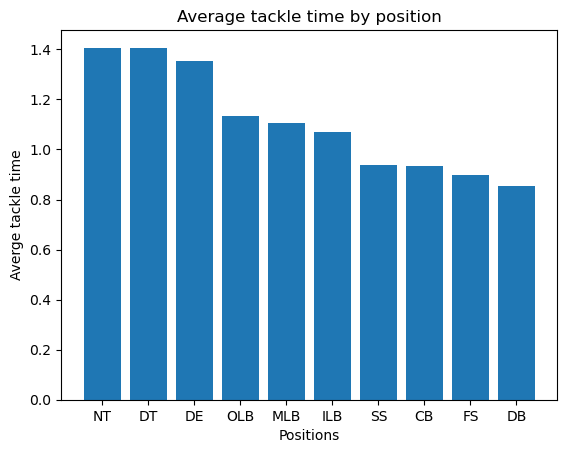

,position,mean.tackle.time
0,CB,0.935172
1,DB,0.855000
2,DE,1.354691
3,DT,1.405229
4,FS,0.896226
5,ILB,1.069864
6,MLB,1.106211
7,NT,1.406734
8,OLB,1.134468
9,SS,0.938454


In [30]:
groups = pivot_tracking.groupby(by = ['gamePlayId'])
sub1 = groups.apply(lambda g: np.unique(g['nflId.tackler'])[0]).reset_index()
sub1.columns = ['gamePlayId', 'nflId']
sub1 = sub1.merge(players, on='nflId', how = 'left')

sub2 = event_times.loc[:,('gamePlayId', 'tackleTime')]
tackle_times = sub1.merge(sub2, on = 'gamePlayId', how='left')

groups = tackle_times.groupby('position')
tt_by_position = groups.apply(lambda g: np.mean(g['tackleTime'])).reset_index()
tt_by_position.columns = ['position', 'mean.tackle.time']

orders = tt_by_position['position'].iloc[tt_by_position['mean.tackle.time'].argsort()]
mean_tackle_times = np.sort(tt_by_position['mean.tackle.time'])
plt.bar(np.flip(orders), np.flip(mean_tackle_times))
plt.xlabel('Positions')  
plt.ylabel('Averge tackle time')  
plt.title('Average tackle time by position')
plt.savefig("Average_tackle_time_by_position.jpg")
plt.show()
tt_by_position

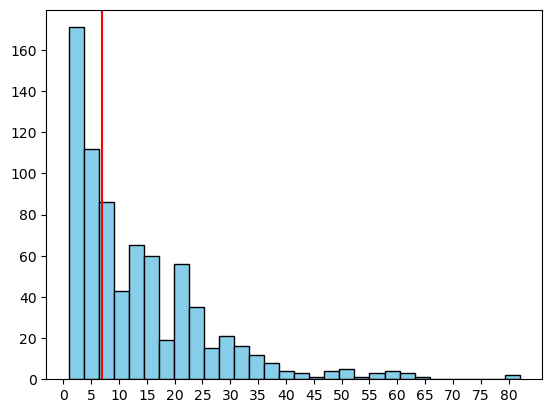

13.38


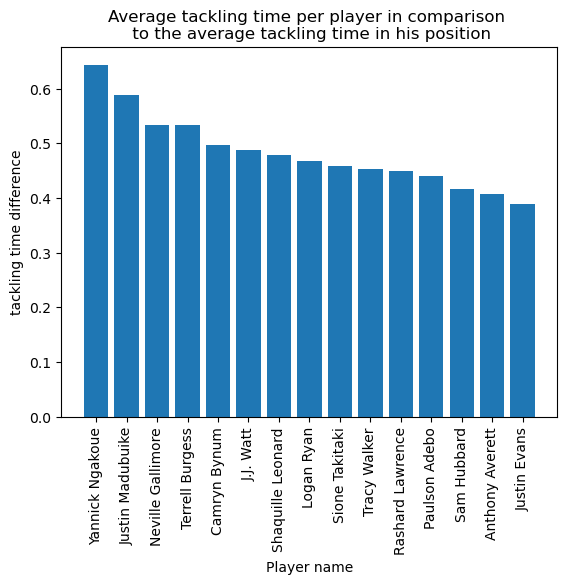

,nflId,displayName,n_tackles,position,club,tt.avg.diff
156,43358.0,Yannick Ngakoue,9,DE,IND,-0.643580
501,52479.0,Justin Madubuike,12,DT,BAL,-0.588562
504,52490.0,Neville Gallimore,7,DT,DAL,-0.533800
514,52512.0,Terrell Burgess,8,FS,LA,-0.533726
616,53554.0,Camryn Bynum,10,FS,MIN,-0.496227
12,37084.0,J.J. Watt,12,DE,ARI,-0.488024
278,46105.0,Shaquille Leonard,7,MLB,IND,-0.477639
46,40031.0,Logan Ryan,7,FS,TB,-0.467655
402,47863.0,Sione Takitaki,25,OLB,CLE,-0.458468
297,46151.0,Tracy Walker,14,FS,DET,-0.453369


In [31]:
groups = tracking_data.groupby('nflId')
clubs = groups.apply(lambda g:  np.unique(g['club'])[0]).reset_index()
clubs.columns = ['nflId', 'club']
tackle_times = tackle_times.merge(clubs, on="nflId", how="left")

def tackle_time_player_vs_avg_tackle_time(group):
    position = np.unique(group['position'])[0]
    display_name = np.unique(group['displayName'])[0]
    pl_avg_time = np.mean(group['tackleTime'])
    club = np.unique(group['club'])[0]
    tt_by_p = tt_by_position.loc[tt_by_position['position'] == position]['mean.tackle.time'].item()
    n_tackles = len(group['gamePlayId'])
    return(pd.Series([display_name, n_tackles, position, club, (pl_avg_time - tt_by_p)]))

groups = tackle_times.groupby('nflId')
tt_acc_to_avg_tt = groups.apply(lambda g: tackle_time_player_vs_avg_tackle_time(g)).reset_index()
tt_acc_to_avg_tt.columns = ['nflId', 'displayName', 'n_tackles', 'position', 'club', 'tt.avg.diff']


#only players with number of tackles >= 8
x = tt_acc_to_avg_tt['n_tackles']
plt.hist(x, bins=30, color='skyblue', edgecolor='black')
plt.xticks(np.arange(0, max(x), 5.0))
plt.axvline(x=7, color='red')
plt.show()

print(np.mean(tt_acc_to_avg_tt['n_tackles']))
sorted_rslt_tt_acc_to_avg_tt = tt_acc_to_avg_tt.loc[tt_acc_to_avg_tt['n_tackles'] >= 7]
sorted_rslt_tt_acc_to_avg_tt = sorted_rslt_tt_acc_to_avg_tt.sort_values(by = 'tt.avg.diff')
top_tacklers = sorted_rslt_tt_acc_to_avg_tt.head(n=15)

orders = top_tacklers['displayName'].iloc[top_tacklers['tt.avg.diff'].argsort()]
tt_avg_diff = np.sort(top_tacklers['tt.avg.diff'])
plt.bar(orders, abs(tt_avg_diff))
plt.xlabel('Player name')  
plt.ylabel('tackling time difference')  
plt.title('Average tackling time per player in comparison \n to the average tackling time in his position')
plt.xticks(rotation = 90)
plt.savefig("Average_tackle_time_by_player.png")
plt.show()

# a negative tt.avg.diff means that the tackler is better than the average tackle time in his position
top_tacklers

In [32]:
df1 = tt_acc_to_avg_tt.groupby(['club', 'position', 'nflId'])['n_tackles'].sum().reset_index()
df2 = df1.loc[:, ('club', 'n_tackles')].groupby('club').sum().reset_index()
df3 = df1.merge(df2, on="club", how = "left")
df3['w'] = df3['n_tackles_x'] / df3['n_tackles_y']
df4 = tt_acc_to_avg_tt.groupby(['club', 'position', 'nflId'])['tt.avg.diff'].sum().reset_index()
weights = df3.loc[:, ('club', 'position',"nflId", 'w')]
df4 = df4.merge(weights, on=["club", "position", "nflId"], how="left")
df4['club.tt.avg.diff'] = df4['tt.avg.diff'] * df4['w']
final_table = df4.groupby('club')['club.tt.avg.diff'].sum().reset_index().sort_values(by = 'club.tt.avg.diff')
final_table.reset_index()

,index,club,club.tt.avg.diff
0,18,LV,-0.146346
1,13,IND,-0.144749
2,10,DET,-0.105479
3,28,SF,-0.074052
4,8,DAL,-0.069053
5,16,LA,-0.053524
6,1,ATL,-0.052640
7,25,PHI,-0.045369
8,30,TEN,-0.044919
9,24,NYJ,-0.036079


<a id = "FeatureEngineering"></a>
# Step 5: Feature engineering

<a id = "DistanceLastFrames"></a>
<h3> Distance of last frames per play</h3>


In [33]:
last_frames = pivot_tracking.sort_values(by=['gamePlayId', 'frameId'])


# Calculate the rolling sum of the last 5-15 distances for each ID
last_frames['dis.tackler.l5f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.tackler.l7f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.tackler.l10f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=10, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.tackler.l15f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True)

last_frames['dis.ballcarrier.l5f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.ballcarrier.l7f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.ballcarrier.l10f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=10, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.ballcarrier.l15f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True)

# Only keep the last value
last_frames = last_frames.groupby('gamePlayId').last().reset_index()

# Join back to pivot_tracking
pivot_tracking = pivot_tracking.merge(last_frames[["gamePlayId",'dis.tackler.l5f', 'dis.tackler.l7f', 'dis.tackler.l10f', 
                                                   'dis.tackler.l15f','dis.ballcarrier.l5f', 'dis.ballcarrier.l7f', 
                                                   'dis.ballcarrier.l10f', 'dis.ballcarrier.l15f']], on='gamePlayId', how='left')

<a id = "SummaryStatistics"></a>
<h3> Summary statistics of existing features </h3>

In [34]:
aggregations = {
    'x.ballcarrier': ["mean"],
    'y.ballcarrier': [ "mean"],  
    'x.tackler': ["mean"], 
    'y.tackler': ["mean"],
    'dir.ballcarrier' : ["mean"],
    'dir.tackler' : [ "mean"],
    'dis.ballcarrier' : ["min", "max", "sum"],
    'dis.tackler' : ["min", "max", "sum"],
    's.ballcarrier' : ["min", "max", "mean"],
    's.tackler' : ["min", "max", "mean"], 
    'dis.tackler.l15f' : ["mean"], 
    'dis.ballcarrier.l15f' : ["mean"]
}

# Group by playId and apply the aggregations
tracking_collapsed = pivot_tracking.groupby('gamePlayId').agg(aggregations).reset_index()

tracking_collapsed.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in tracking_collapsed.columns]
tracking_collapsed

,gamePlayId,x.ballcarrier_mean,y.ballcarrier_mean,x.tackler_mean,y.tackler_mean,dir.ballcarrier_mean,dir.tackler_mean,dis.ballcarrier_min,dis.ballcarrier_max,dis.ballcarrier_sum,...,dis.tackler_max,dis.tackler_sum,s.ballcarrier_min,s.ballcarrier_max,s.ballcarrier_mean,s.tackler_min,s.tackler_max,s.tackler_mean,dis.tackler.l15f_mean,dis.ballcarrier.l15f_mean
0,202209080056,79.591364,34.885909,78.350000,36.037727,156.100000,155.476364,0.01,0.62,5.62,...,0.60,7.84,0.42,6.24,2.523636,0.46,6.02,3.486818,3.79,1.78
1,202209080080,77.716333,36.815667,73.819667,38.147667,319.879000,186.184667,0.34,0.79,18.55,...,0.57,10.15,3.10,7.89,6.173667,0.42,5.77,3.461333,7.49,9.57
2,202209110057,35.540870,18.451957,40.085000,21.167174,149.288261,168.495652,0.18,0.92,31.46,...,0.89,28.55,1.98,9.18,6.850652,2.01,8.88,6.230652,11.51,11.20
3,202209110078,44.289877,24.748765,56.736173,21.225556,107.104691,164.510617,0.00,0.68,29.41,...,0.67,31.04,0.00,6.80,3.617037,0.24,6.73,3.826049,1.77,3.12
4,202209110185,24.266538,37.136538,25.656923,37.373846,202.229615,251.876154,0.08,0.59,8.09,...,0.72,12.83,0.97,5.80,3.169231,3.32,7.25,4.897692,5.69,3.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,20221107003658,69.218305,24.181525,66.248814,27.246441,182.784576,171.971017,0.00,0.56,16.68,...,0.62,19.94,0.00,5.66,2.873898,0.04,5.96,3.266610,4.33,2.77
10031,20221107003686,63.494211,27.632632,59.678421,27.146711,288.136842,171.161711,0.00,0.54,15.61,...,0.42,13.77,0.00,5.39,1.769605,0.01,4.27,1.791053,1.39,2.12
10032,20221107003707,61.283276,30.654138,56.428103,30.537759,270.885345,126.444655,0.01,0.52,14.58,...,0.48,11.44,0.01,5.23,2.515345,0.01,4.80,1.983621,1.76,2.89
10033,20221107003740,62.991190,24.505238,59.094286,22.466905,203.105476,127.072857,0.00,0.72,15.92,...,0.73,17.08,0.00,7.21,3.782857,0.01,7.12,3.958333,9.53,8.54


<a id = "ConvexHull"></a>
<h3> Convex Hull </h3>

In [35]:
from scipy.spatial import ConvexHull
def calc_hull(df, id, frame):
    play = df[df["gamePlayId"] == id]
    frame = play[play["frameId"] == frame]
    if len(frame) < 3:
        return 0.0
    points = frame[["x", "y"]].to_numpy()
    hull = ConvexHull(points)
    return hull.volume

In [36]:
#event_times_df = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/event_times.csv")

In [37]:
# gameplayid = event_times_df["gamePlayId"].to_numpy()
# frames = event_times_df["firstContact"].to_numpy()
# #ACHTUNG dauert ca 90 min +-
# hulls_first_contact = []
# for i, x in enumerate(gameplayid):
#      hulls_first_contact.append(calc_hull(merged_df, x, frames[i]))
# event_times["ConvexHullFirstContact"] = hulls_first_contact
# event_times.to_csv("event_times+Convex_fC.csv")

In [38]:
# gameplayid = event_times_df["gamePlayId"].to_numpy()
# frames = event_times_df["tackle"].to_numpy()
# #ACHTUNG dauert ca 90 min +-
# hulls_tackle = []
# for i, x in enumerate(gameplayid):
#      hulls_tackle.append(calc_hull(merged_df, x, frames[i]))
# event_times["ConvexHulltackle"] = hulls_tackle
# event_times.to_csv("event_times+Convex_t.csv")

In [39]:
#df = merged_df[['gamePlayId', 'frameId', 'nflId', 'displayName', 'x', 'y']]

# # Create an empty list to store the results
# results = []

# # Iterate through unique gamePlayIds
# for gamePlayId in df['gamePlayId'].unique():
#     # Filter the DataFrame for the current play
#     play_df = df[df['gamePlayId'] == gamePlayId]
    
#     # Find the coordinates of the football in each frame
#     football_coords = play_df[play_df['displayName'] == 'football'][['frameId', 'x', 'y']]
    
#     # Iterate through the frames in the current play
#     for frame in play_df.iterrows():
#         frame = frame[1]
#         frame_coords = np.array([frame['x'], frame['y']])
        
#         # Find the corresponding football coordinates for this frame
#         football_frame_coords = football_coords[football_coords['frameId'] == frame['frameId']][['x', 'y']].values
        
#         if len(football_frame_coords) > 0:
#             # Calculate the Euclidean distance between player and football for this frame
#             distance = np.linalg.norm(frame_coords - football_frame_coords[0])
            
#             # Add the distance to the results
#             results.append({'gamePlayId': gamePlayId, 'frameId': frame['frameId'], 'nflId': frame['nflId'], 'Distance to Football': distance})

# # Create a new DataFrame with the results
# results_df = pd.DataFrame(results)

# # Display the results
# print(results_df)

In [40]:
# results_df = pd.read_csv("distance_df.csv", index_col=0)
# extr = results_df["distanceToFootball"].to_numpy()
# merged_df["distanceToFootball"] = extr

In [41]:
# gameplayid = event_times["gamePlayId"].to_numpy()
# frames = event_times["tackle"].to_numpy()
# #ACHTUNG dauert ca 90 min +-
# hulls_tackle_3y = []
# for i, x in enumerate(gameplayid):
#      hulls_tackle_3y.append(calc_hull(filtered_df, x, frames[i]))
# event_times["ConvexHulltackle5y"] = hulls_tackle_3y

In [42]:
# gameplayid = event_times["gamePlayId"].to_numpy()
# frames = event_times["firstContact"].to_numpy()
# #ACHTUNG dauert ca 90 min +-
# hulls_firstContact_5y = []
# for i, x in enumerate(gameplayid):
#      hulls_firstContact_5y.append(calc_hull(filtered_df, x, frames[i]))
# event_times["ConvexHullFirstContact5y"] = hulls_firstContact_5y

In [43]:
# event_times["ConvexHullTackle5y"] = hulls_tackle_3y
# event_times["ConvexHullFirstContact5y"] = hulls_firstContact_5y
# event_times.to_csv("event_times_hull.csv")

In [44]:
#read in computed convex hull
convexHull  = pd.read_csv(dir + "event_times_hull.csv")

<a id = "additionalVariables"></a>
<h3> Additional variables from the plays and players datasets</h3>

The play and player dataset contain additional covariates 

In [45]:
#change nflId to int
pivot_tracking['nflId.ballcarrier'] = pivot_tracking['nflId.ballcarrier'].astype("int64")
pivot_tracking['nflId.tackler'] = pivot_tracking['nflId.tackler'].astype("int64")

In [46]:
# add weight and height for ballcarrier

list_of_columns = ["nflId.tackler","nflId.ballcarrier","gamePlayId","height", "weight", "position"]

tracking_tmp = pd.merge(pivot_tracking, players, left_on='nflId.ballcarrier',right_on="nflId", how='left')[list_of_columns]
tracking_tmp = tracking_tmp.rename(columns={
    'height': 'ballcarrier.height',
    'weight': 'ballcarrier.weight',
    'position': 'ballcarrier.position'
})

# add weight and height for tackler

list_of_columns = list(tracking_tmp.columns)
list_of_columns.extend(["height", "weight", "position"])
tracking_tmp = pd.merge(tracking_tmp, players, left_on='nflId.tackler',right_on="nflId", how='left')[list_of_columns]
tracking_tmp = tracking_tmp.rename(columns={
    'height': 'tackler.height',
    'weight': 'tackler.weight',
    'position': 'tackler.position'
})

# add more covariates form plays: playDescription, quarter, down, 
#                                 yardsToGo, yardlineNumber, passLength, 
#                                 offenseFormation, defendersInTheBox  

list_of_columns = list(tracking_tmp.columns)
list_of_columns.extend([ "quarter", "down", 
                        "yardsToGo", "yardlineNumber", "passLength", 
                        "offenseFormation", "defendersInTheBox"])

tracking_tmp = pd.merge(tracking_tmp, plays, on="gamePlayId", how='left')[list_of_columns] 

nflId.tackler                0
nflId.ballcarrier            0
gamePlayId                   0
ballcarrier.height           0
ballcarrier.weight           0
ballcarrier.position         0
tackler.height               0
tackler.weight               0
tackler.position             0
quarter                      0
down                         0
yardsToGo                    0
yardlineNumber               0
passLength              317019
offenseFormation            72
defendersInTheBox           72
dtype: int64


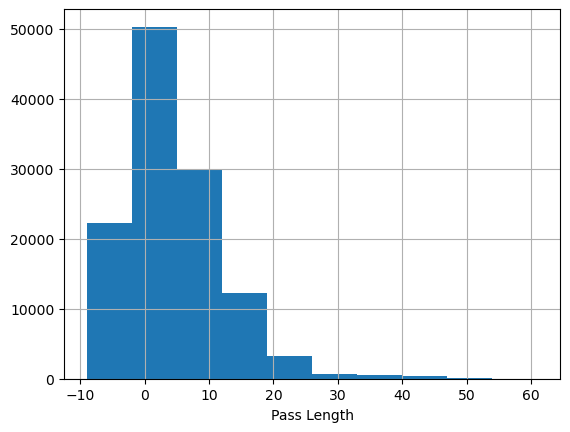

1.0
11.0


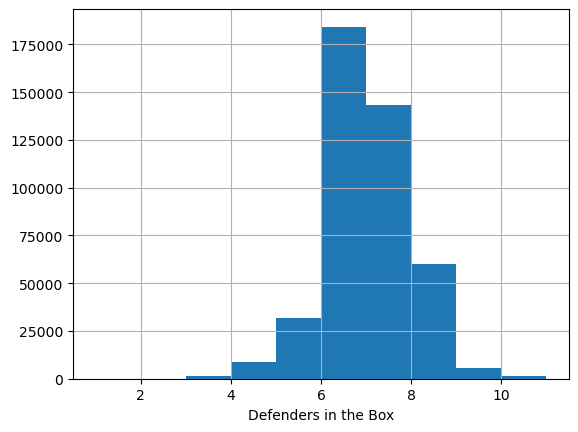

offenseFormation
SHOTGUN       197570
SINGLEBACK    146911
I_FORM         40210
PISTOL         24297
EMPTY          19794
JUMBO           3976
WILDCAT         3727
Name: count, dtype: int64
['SHOTGUN' 'EMPTY' 'PISTOL' 'I_FORM' 'SINGLEBACK' 'JUMBO' 'WILDCAT' nan]


In [47]:
#ask what to do with the NaN values in pass lenght
nan_counts = tracking_tmp.isna().sum()
print(nan_counts)

#look into pass Lenght

tracking_tmp['passLength'].hist(bins=10)
plt.xlabel('Pass Length')
plt.show()

#only in about 25% of the data pass Length occurs 
#create a flag for that reason 
#its because running play, set pass lenght to 0 

tracking_tmp["passLength"] = tracking_tmp["passLength"].fillna(0)

tracking_tmp['containsPassLength'] = tracking_tmp['passLength'].notna()

#Look at defendersInTheBox
tracking_tmp['defendersInTheBox'].hist(bins=10)

plt.xlabel('Defenders in the Box')

min_def = tracking_tmp["defendersInTheBox"].min()
max_def = tracking_tmp["defendersInTheBox"].max()

print(min_def)
print(max_def)

plt.show()

#fill NaN of defendersInTheBox with 0
tracking_tmp["defendersInTheBox"] = tracking_tmp["defendersInTheBox"].fillna(0)
tracking_tmp["defendersInTheBox"] = tracking_tmp["defendersInTheBox"].astype("int64")
tracking_tmp

#Look at diffrent Formations
value_counts_offence = tracking_tmp["offenseFormation"].value_counts()
unique_offence = tracking_tmp["offenseFormation"].unique()

print(value_counts_offence)
print(unique_offence)
plt.show()

#fill NaN of offenseFormation with NoFormation
tracking_tmp["offenseFormation"] = tracking_tmp["offenseFormation"].fillna("0")
tracking_tmp = pd.get_dummies(tracking_tmp, columns = ['offenseFormation']) 

# encode positoins as dummies
tracking_tmp = pd.get_dummies(tracking_tmp, columns = ['ballcarrier.position']) 
tracking_tmp = pd.get_dummies(tracking_tmp, columns = ['tackler.position']) 
tracking_tmp.drop_duplicates(inplace=True)

In [48]:
#prepare for later merge

tracking_tmp = tracking_tmp.drop("nflId.tackler", axis=1)
tracking_tmp = tracking_tmp.drop("nflId.ballcarrier", axis=1)

In [49]:
tracking_tmp

,gamePlayId,ballcarrier.height,ballcarrier.weight,tackler.height,tackler.weight,quarter,down,yardsToGo,yardlineNumber,passLength,...,tackler.position_CB,tackler.position_DB,tackler.position_DE,tackler.position_DT,tackler.position_FS,tackler.position_ILB,tackler.position_MLB,tackler.position_NT,tackler.position_OLB,tackler.position_SS
0,202209080056,6-0,191,6-1,208,1,1,10,25,5.0,...,True,False,False,False,False,False,False,False,False,False
22,202209080080,6-5,237,6-2,230,1,2,4,31,0.0,...,False,False,False,False,False,True,False,False,False,False
52,202209110057,6-4,222,6-3,242,1,1,10,25,0.0,...,False,False,False,False,False,False,False,False,True,False
98,202209110078,6-2,238,5-9,190,1,1,10,36,0.0,...,False,False,False,False,True,False,False,False,False,False
179,202209110185,5-11,205,6-1,230,1,2,10,22,-7.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436278,20221107003658,6-1,211,6-7,289,4,3,1,44,0.0,...,False,False,True,False,False,False,False,False,False,False
436337,20221107003686,6-1,211,6-3,240,4,1,10,46,0.0,...,False,False,False,False,False,False,False,False,True,False
436413,20221107003707,6-1,211,6-3,240,4,2,5,49,0.0,...,False,False,False,False,False,False,False,False,True,False
436471,20221107003740,6-1,211,6-5,261,4,3,1,45,0.0,...,False,False,True,False,False,False,False,False,False,False


<a id="anglesMovement"> </a>
<h3> Orientation angle and movement direction </h3>

**mean difference between direction and orientation angle**

In [50]:
pivot_tracking['orientation_movement_diff_ballcarrier'] = abs(pivot_tracking['dis.ballcarrier'] - pivot_tracking['a.ballcarrier'])

pivot_tracking['orientation_movement_diff_tackler'] = abs(pivot_tracking['dis.tackler'] - pivot_tracking['a.tackler'])

result = pivot_tracking.groupby('gamePlayId').agg({'orientation_movement_diff_ballcarrier': 'mean', 'orientation_movement_diff_tackler': 'mean'}).reset_index()
tracking_tmp = tracking_tmp.merge(result, on="gamePlayId", how="left")

**mean absolute difference between direction angles of ballcarrier and tackler**

In [51]:
pivot_tracking['abs_diff_direction'] = abs(pivot_tracking['dis.ballcarrier'] - pivot_tracking['dis.tackler'])

result_abs_diff_direction = pivot_tracking.groupby('gamePlayId').agg({'abs_diff_direction': 'mean'}).reset_index()
tracking_tmp = tracking_tmp.merge(result_abs_diff_direction, on="gamePlayId", how="left")

In [52]:
pivot_tracking['abs_diff_direction'] = abs(pivot_tracking['dis.ballcarrier'] - pivot_tracking['dis.tackler'])

tackle_events = pivot_tracking[pivot_tracking['event'] == "tackle"]
first_contact_events = pivot_tracking[pivot_tracking['frameId'] == pivot_tracking["firstContact"]]

# Group by gamePlayId and calculate the mean for each group
result_tackle = tackle_events.groupby('gamePlayId').agg({'abs_diff_direction': 'mean'}).reset_index()
result_tackle.columns = ["gamePlayId", "difference_direction_tackle"]
result_first_contact = first_contact_events.groupby('gamePlayId').agg({'abs_diff_direction': 'mean'}).reset_index()
result_first_contact.columns = ["gamePlayId", "difference_direction_first_contact"]
tracking_tmp = tracking_tmp.merge(result_tackle, on="gamePlayId", how="left")
tracking_tmp = tracking_tmp.merge(result_first_contact, on="gamePlayId", how="left")

**mean difference between direction at time of tackle**

<a id="TurningAngle"> </a>
<h3> Turning angle </h3>

In [53]:
# determine turning angle for tackler and ballcarrier
pivot_tracking.sort_values(by=['gamePlayId', 'frameId'], inplace=True)

columns_to_diff = ['dir.ballcarrier', 'dir.tackler']  # Add more if needed

# Calculate absolute differences for each column
for column in columns_to_diff:
    diff_column = f'{column}_diff'
    pivot_tracking[diff_column] = pivot_tracking.groupby('gamePlayId')[column].diff().abs().fillna(0)

pivot_tracking.rename(columns= {"dir.ballcarrier_diff": "turning_angle.ballcarrier", "dir.tackler_diff" : "turning_angle.tackler"}, inplace=True)

<h4> Average over n frames before first contact </h4>

In [54]:
# determine first contact frames
first_contact_frames = pivot_tracking[(pivot_tracking["frameId"] == pivot_tracking["firstContact"])][["gamePlayId", "firstContact"]]

indices = list(first_contact_frames.index)
frames = list(first_contact_frames["firstContact"].astype("int64"))

# function that caluclates the average of turning angles for n frames before the the event
def calculate_average(index, fc_frame, n):
    
    steps_back = min(n, fc_frame)
    start_index = max(0, index - steps_back)  # Adjust the number of rows based on the integer number
    selected_rows = pivot_tracking.iloc[start_index:index]
    ballcarrier_average = round(selected_rows['turning_angle.ballcarrier'].mean(),3)
    tackler_average = round(selected_rows['turning_angle.tackler'].mean(),3)

    return (ballcarrier_average, tackler_average)


# Use the function for each index and corresponding frameId in the lists
ballcarrier_averages_5f, tackler_averages_5f = zip(*[calculate_average(index, frame, 5) for index, frame in zip(indices, frames)])
ballcarrier_averages_7f, tackler_averages_7f = zip(*[calculate_average(index, frame, 7) for index, frame in zip(indices, frames)])
ballcarrier_averages_10f, tackler_averages_10f = zip(*[calculate_average(index, frame, 10) for index, frame in zip(indices, frames)])


tracking_tmp["turning_angle_avg_pre_fc.ballcarrier.l5f"] = ballcarrier_averages_5f
tracking_tmp["turning_angle_avg_pre_fc.ballcarrier.l7f"] = ballcarrier_averages_7f
tracking_tmp["turning_angle_avg_pre_fc.ballcarrier.l10f"] = ballcarrier_averages_10f
tracking_tmp["turning_angle_avg_pre_fc.tackler.l5f"] = tackler_averages_5f
tracking_tmp["turning_angle_avg_pre_fc.tackler.l7f"] = tackler_averages_7f
tracking_tmp["turning_angle_avg_pre_fc.tackler.l10f"] = tackler_averages_10f

<h3> Turning angle average of n frames before tackle </h3>

In [55]:
tackle_frames = pivot_tracking[(pivot_tracking["event"] == "tackle")][["gamePlayId", "frameId", "turning_angle.ballcarrier", "turning_angle.tackler"]]

indices = list(tackle_frames.index)
frames = list(tackle_frames["frameId"].astype("int64"))

balllcarrier_averages_5f, tackler_averages_5f = zip(*[calculate_average(index, frame, 5) for index, frame in zip(indices, frames)])
balllcarrier_averages_7f, tackler_averages_7f = zip(*[calculate_average(index, frame, 7) for index, frame in zip(indices, frames)])
balllcarrier_averages_10f, tackler_averages_10f = zip(*[calculate_average(index, frame, 10) for index, frame in zip(indices, frames)])


tracking_tmp["turning_angle_avg_pre_tackle.ballcarrier.l5f"] = balllcarrier_averages_5f
tracking_tmp["turning_angle_avg_pre_tackle.ballcarrier.l7f"] = balllcarrier_averages_7f
tracking_tmp["turning_angle_avg_pre_tackle.ballcarrier.l10f"] = balllcarrier_averages_10f
tracking_tmp["turning_angle_avg_pre_tackle.tackler.l5f"] = tackler_averages_5f
tracking_tmp["turning_angle_avg_pre_tackle.tackler.l7f"] = tackler_averages_7f
tracking_tmp["turning_angle_avg_pre_tackle.tackler.l10f"] = tackler_averages_10f

<h3> Turning angle at tackle </h3>

In [56]:
tracking_tmp["turning_angle_at_tackle.ballcarrier"] = tackle_frames.reset_index()["turning_angle.ballcarrier"]
tracking_tmp["turning_angle_at_tackle.tackler"] = tackle_frames.reset_index()["turning_angle.tackler"]

<h3> Turning angle average after tackle </h3>

In [57]:
last_play_ids = pivot_tracking.groupby("gamePlayId")["frameId"].max().reset_index()
tackle_frames.reset_index(inplace=True)
tackle_frames["last_play_frameIds"] = last_play_ids["frameId"]
tackle_frames["last_play_frameIds"] = last_play_ids["frameId"]
tackle_frames.set_index("index", inplace=True)


indices = list(tackle_frames.index)
frames = list(tackle_frames["frameId"].astype("int"))
last_play_frameIds = list(tackle_frames["last_play_frameIds"].astype("int64"))

# function that caluclates the average of turning angles frames after the the event
def calculate_average_after_event(index, tackle_frame, last_frameId):
    
    step_forward = last_frameId - tackle_frame
    end_index = index + step_forward + 1
    selected_rows = pivot_tracking.iloc[index:end_index]
    ballcarrier_average = round(selected_rows['turning_angle.ballcarrier'].mean(),3)
    tackler_average = round(selected_rows['turning_angle.tackler'].mean(),3)

    return (ballcarrier_average, tackler_average)


# Use the function for each index and corresponding frameId in the lists
ballcarrier_averages, tackler_averages = zip(*[calculate_average_after_event(index, frame, last_frame) for index, frame, last_frame in zip(indices, frames,last_play_frameIds)])


tracking_tmp["turning_angle_avg_after_tackle.tackler"] = tackler_averages
tracking_tmp["turning_angle_avg_after_tackle.ballcarrier"] = ballcarrier_averages

<a id="AddFeatures"> </a>
<h2> Add features to the collapsed tracking data set </h2>

In [58]:
tracking_collapsed = tracking_collapsed.merge(tracking_tmp, on="gamePlayId", how="left")
tracking_collapsed = tracking_collapsed.merge(convexHull[["gamePlayId","ConvexHullFirstContact", "ConvexHulltackle", "ConvexHullTackle5y","ConvexHullFirstContact5y"]], on="gamePlayId", how="left")

# convert height to cm 
conversions = [30.48, 2.54]
tracking_collapsed['ballcarrier.height'] = tracking_collapsed['ballcarrier.height'].str.split('-').apply(pd.Series).astype("int64").dot(conversions)
tracking_collapsed['tackler.height'] = tracking_collapsed['tackler.height'].str.split('-').apply(pd.Series).astype("int64").dot(conversions)

<a id="AddResponse"> </a>
<h3> Add tackling time as response </h3>

In [59]:
tracking_collapsed = tracking_collapsed.merge(event_times[["gamePlayId","tackleTime"]], on="gamePlayId", how="left")
tracking_collapsed

,gamePlayId,x.ballcarrier_mean,y.ballcarrier_mean,x.tackler_mean,y.tackler_mean,dir.ballcarrier_mean,dir.tackler_mean,dis.ballcarrier_min,dis.ballcarrier_max,dis.ballcarrier_sum,...,turning_angle_avg_pre_tackle.tackler.l10f,turning_angle_at_tackle.ballcarrier,turning_angle_at_tackle.tackler,turning_angle_avg_after_tackle.tackler,turning_angle_avg_after_tackle.ballcarrier,ConvexHullFirstContact,ConvexHulltackle,ConvexHullTackle5y,ConvexHullFirstContact5y,tackleTime
0,202209080056,79.591364,34.885909,78.350000,36.037727,156.100000,155.476364,0.01,0.62,5.62,...,3.955,9.77,12.18,12.856,5.458,479.362398,485.406668,2.451700,2.051150,0.300001
1,202209080080,77.716333,36.815667,73.819667,38.147667,319.879000,186.184667,0.34,0.79,18.55,...,38.676,3.37,2.23,1.940,3.380,622.321750,540.074550,5.351100,3.524700,0.600001
2,202209110057,35.540870,18.451957,40.085000,21.167174,149.288261,168.495652,0.18,0.92,31.46,...,2.183,1.53,0.62,2.054,2.014,449.396250,389.018800,8.192200,4.619499,0.500000
3,202209110078,44.289877,24.748765,56.736173,21.225556,107.104691,164.510617,0.00,0.68,29.41,...,10.263,0.93,2.29,3.912,2.564,266.420000,293.662550,22.768950,5.296600,0.699999
4,202209110185,24.266538,37.136538,25.656923,37.373846,202.229615,251.876154,0.08,0.59,8.09,...,8.726,8.80,2.86,2.012,5.054,620.230585,776.237700,7.284200,0.793998,1.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,20221107003658,69.218305,24.181525,66.248814,27.246441,182.784576,171.971017,0.00,0.56,16.68,...,1.493,23.65,0.28,1.550,45.788,433.366850,439.124800,23.570400,23.151150,1.500000
10031,20221107003686,63.494211,27.632632,59.678421,27.146711,288.136842,171.161711,0.00,0.54,15.61,...,11.014,0.99,4.01,9.510,1.530,118.728150,86.418650,26.728900,19.930600,4.099999
10032,20221107003707,61.283276,30.654138,56.428103,30.537759,270.885345,126.444655,0.01,0.52,14.58,...,5.547,7.90,2.56,3.516,11.524,173.270500,194.691000,6.897396,9.437350,1.500000
10033,20221107003740,62.991190,24.505238,59.094286,22.466905,203.105476,127.072857,0.00,0.72,15.92,...,3.735,0.45,1.82,1.280,0.546,147.247000,184.556750,0.454000,1.812199,0.700000


<h3> Save tracking_collapsed

In [60]:
tracking_collapsed.to_csv('tracking_collapsed.csv',index=False)

<a id="model"> </a> 
<h1> Step 6: The Model </h1>

We first take a look at the general importance of our features using a random forest. Afterwards we extract the most important features and use them to train a GAM to model the tackling time. 

In [61]:
covariates = [col for col in tracking_collapsed.columns if col != "gamePlayId" and col != "tackleTime"]
X = tracking_collapsed[covariates]
y = tracking_collapsed["tackleTime"]

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn import svm

def train_regressor(mod, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    n, k = X_train.shape
    
    adjusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))
    return (r2, adjusted_r2)

<a id="featureSelection"></a>
<h3> Feature selection </h3> 

Since we have constructed many features, we check the initial feature importance using a random forest regressor.

In [63]:
rf = RandomForestRegressor(max_depth=7, n_jobs=3)

print(train_regressor(rf, X, y))

importances = rf.feature_importances_
importances

(0.4278100926091518, 0.42212274954374196)


array([3.68193878e-03, 2.90790415e-03, 2.77529802e-03, 2.56546712e-03,
       4.44134196e-03, 4.10225108e-03, 6.29030873e-04, 2.79681173e-03,
       1.62806582e-01, 4.99646119e-03, 2.70233676e-03, 5.36535694e-02,
       1.63962460e-03, 4.17597288e-03, 1.29318074e-02, 3.81649340e-03,
       6.12457016e-03, 9.77183730e-03, 3.26610805e-01, 1.05045414e-01,
       1.71781343e-03, 3.94474733e-03, 2.09810663e-03, 1.06411226e-02,
       6.36669665e-04, 3.85719563e-04, 8.91759902e-04, 2.42446924e-03,
       5.41800175e-03, 7.31116363e-04, 0.00000000e+00, 0.00000000e+00,
       8.09375020e-05, 2.91674348e-04, 0.00000000e+00, 7.18858248e-05,
       3.46125065e-04, 3.79639472e-04, 6.44381173e-06, 0.00000000e+00,
       4.22329932e-04, 4.67409441e-04, 1.78787575e-04, 1.63251678e-04,
       1.20884818e-04, 1.45477944e-05, 2.63116822e-04, 1.02524339e-04,
       1.14995462e-04, 6.97072392e-05, 2.43264450e-04, 2.50315062e-05,
       3.06518119e-04, 6.32049786e-05, 3.69939600e-02, 1.02709420e-02,
      

Text(0.5, 0, 'Random Forest Feature Importance')

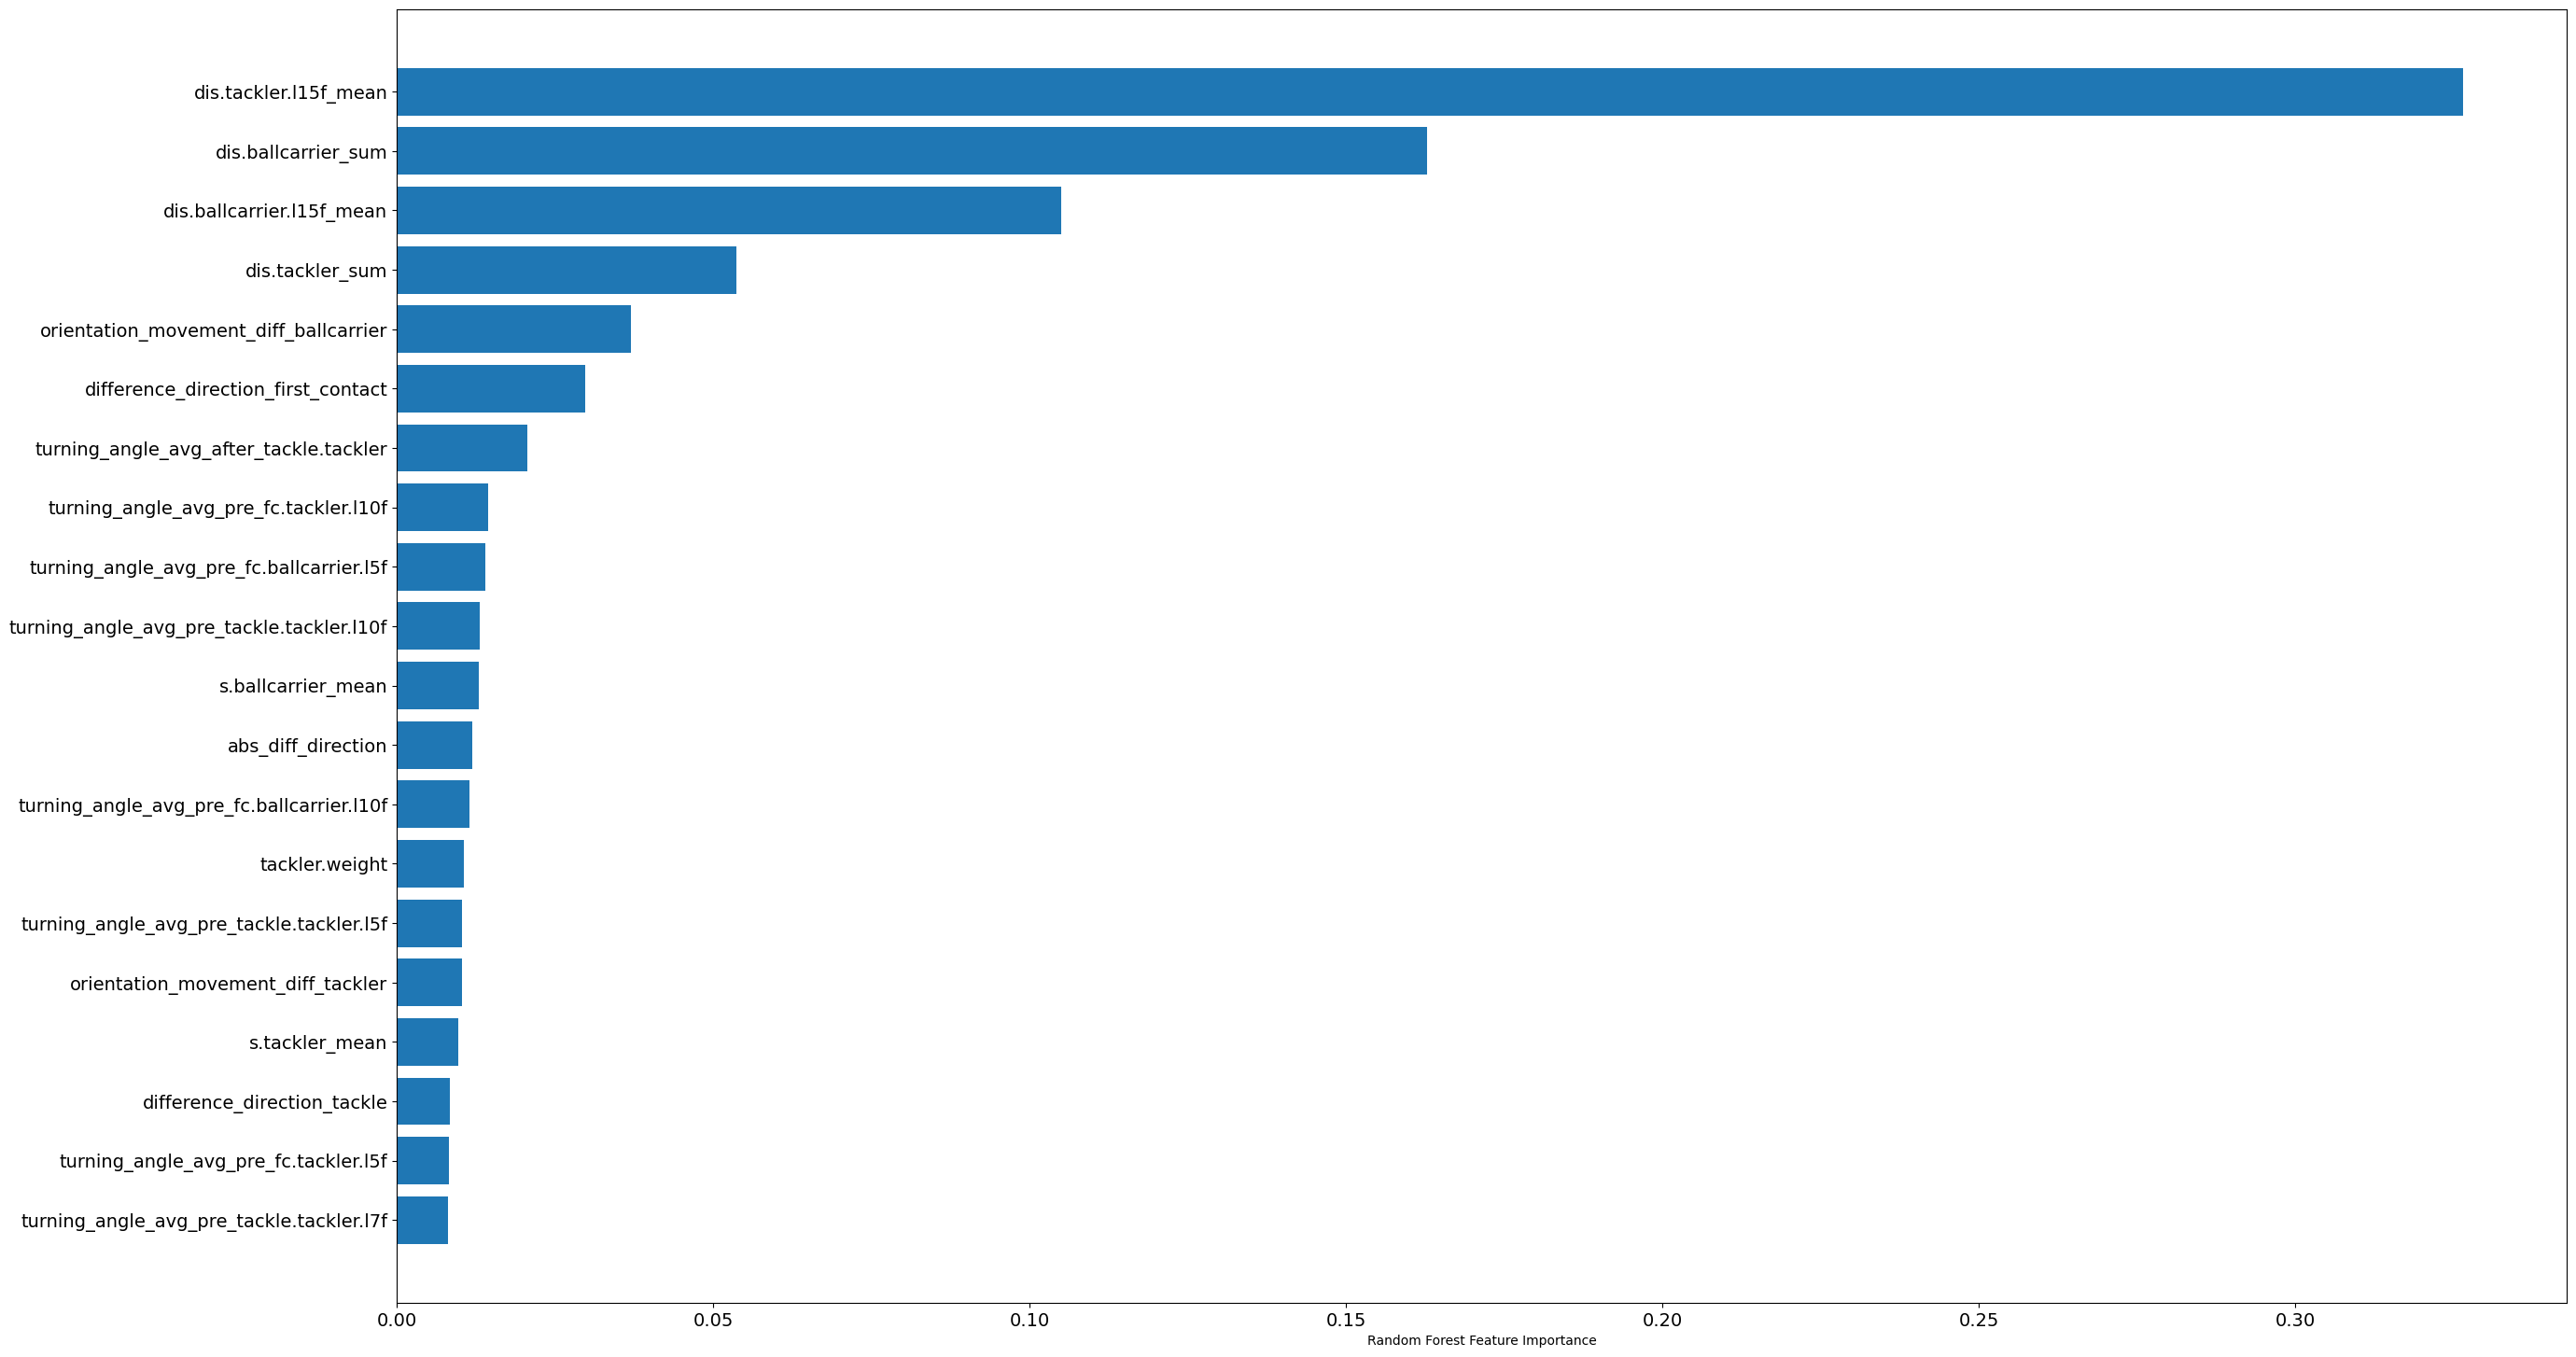

In [64]:
plt.figure(figsize=(30,18))

# Create a horizontal bar chart
sorted_idx = importances.argsort()
plt.barh(np.array(covariates)[sorted_idx][-20:], importances[sorted_idx][-20:])
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel("Random Forest Feature Importance")

<a id="importantFeatures"> </a>
<h3> Extract n most important features </h3>

In [65]:
most_important_covariates = np.flip(np.array(covariates)[sorted_idx])[0:35]
most_important_covariates

array(['dis.tackler.l15f_mean', 'dis.ballcarrier_sum',
       'dis.ballcarrier.l15f_mean', 'dis.tackler_sum',
       'orientation_movement_diff_ballcarrier',
       'difference_direction_first_contact',
       'turning_angle_avg_after_tackle.tackler',
       'turning_angle_avg_pre_fc.tackler.l10f',
       'turning_angle_avg_pre_fc.ballcarrier.l5f',
       'turning_angle_avg_pre_tackle.tackler.l10f', 's.ballcarrier_mean',
       'abs_diff_direction', 'turning_angle_avg_pre_fc.ballcarrier.l10f',
       'tackler.weight', 'turning_angle_avg_pre_tackle.tackler.l5f',
       'orientation_movement_diff_tackler', 's.tackler_mean',
       'difference_direction_tackle',
       'turning_angle_avg_pre_fc.tackler.l5f',
       'turning_angle_avg_pre_tackle.tackler.l7f', 'ConvexHulltackle',
       'turning_angle_avg_pre_fc.tackler.l7f', 's.tackler_max',
       'turning_angle_avg_pre_tackle.ballcarrier.l10f',
       'turning_angle_avg_pre_fc.ballcarrier.l7f', 'passLength',
       'dis.tackler_min', 'di

In [66]:
top_six = ['y.ballcarrier_mean', 'dis.tackler_min', 'x.tackler_mean', 'dis.tackler_sum', 'dir.ballcarrier_mean', 'dis.ballcarrier_min']

In [67]:
#X_new = tracking_collapsed[most_important_covariates]
X_new = tracking_collapsed[top_six]

In [68]:
rf_new = RandomForestRegressor()
print(train_regressor(rf_new, X_new, y))

importances = rf_new.feature_importances_

importances

(0.1006136524565433, 0.09994087872692592)


array([0.19266376, 0.14395264, 0.17295257, 0.23807185, 0.1960113 ,
       0.05634787])

<a id="GAM"></a>
<h3> Train GAM on important features </h3>

In [69]:
from pygam import GAM, s
from sklearn.model_selection import train_test_split
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [70]:
# Defining the GAM model with spline terms for each feature
n_splines = 50
#so = 2
gam = GAM(s(0, n_splines=n_splines, spline_order=2) + s(1, n_splines=n_splines, spline_order=2) + 
          s(2, n_splines=n_splines, spline_order=2) + s(3, n_splines=n_splines, spline_order=2) + 
          s(4, n_splines=n_splines, spline_order=2) + s(5, n_splines=n_splines, spline_order=2),            
                fit_intercept = True, distribution='normal', link='log')

# Fitting the model to the training data
d1 = datetime.now()
gam.fit(X_train, y_train)
d2 = datetime.now()
print((d2 - d1).total_seconds()/60)

lams = np.random.rand(3, 6)
lams = lams * 6 - 3
lams = 3 ** lams 
gam.gridsearch(X_train, y_train, lam=lams)

# Evaluating the model on the test set

gam.summary()

  0% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

0.26640943333333333


100% (3 of 3) |##########################| Elapsed Time: 0:00:38 Time:  0:00:380:12


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    208.9948
Link Function:                          LogLink Log Likelihood:                                 -8468.4663
Number of Samples:                         7024 AIC:                                            17356.9221
                                                AICc:                                           17369.9289
                                                GCV:                                                0.5926
                                                Scale:                                               0.561
                                                Pseudo R-Squared:                                   0.1922
Feature Function                  Lam

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = gam.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#n,k = X_train.shape
#adj_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))
#print(mse, adj_r2, r2)
print(mse)

0.6498421442269721


<Axes: xlabel='tackleTime', ylabel='Density'>

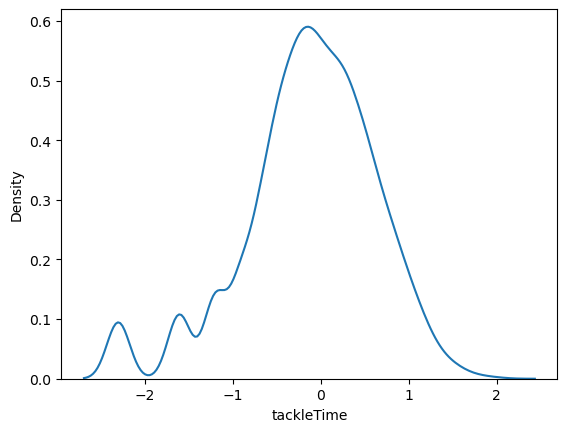

In [72]:
import seaborn as sns

sns.kdeplot(data=y_train, x=np.log(y_train))

In [73]:
print(X_train.columns)

Index(['y.ballcarrier_mean', 'dis.tackler_min', 'x.tackler_mean',
       'dis.tackler_sum', 'dir.ballcarrier_mean', 'dis.ballcarrier_min'],
      dtype='object')


6


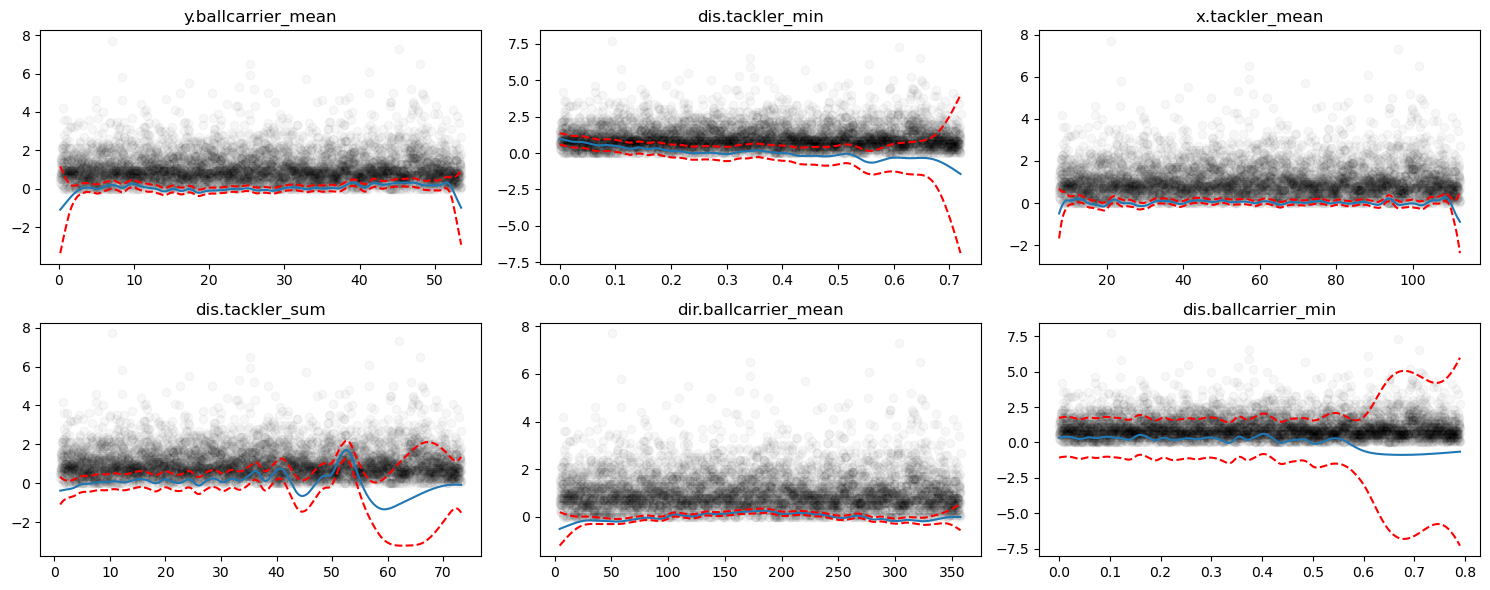

In [74]:
import matplotlib.pyplot as plt

covs = [0,1,2,3,4,5]
print(len(covs))

nrows, ncols = 2, 3

figsize_width = 15  
figsize_height_per_row = 3  
fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_width, nrows * figsize_height_per_row))
fig.tight_layout()

# Plot the data in each subplot
for i, ax in enumerate(axs.flatten()):  # axs.flatten() creates a 1-D array of axes
    XX = gam.generate_X_grid(term=i, n=5000)
    ax.plot(XX[:, covs[i]], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, covs[i]], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.scatter(XX[:,covs[i]], y[0:5000], alpha=.03, color='k')
    ax.set_title(X_train.columns[covs[i]])
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('gam_plots/s' + str(covs[i]) + '.png', bbox_inches=extent.expanded(1.15, 1.3))
    if(i==len(covs)-1):
        break

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.tight_layout()

plt.savefig('gam_plots/gam_plots_full.png')
plt.show()

<a id="Visualization"></a>
# Visualization

<a id="footballField"> </a>
## 1. Plot Football Field

In [75]:
# https://deepnote.com/@yogesh_kumar/NFL-4a717900-6a1e-4390-8671-f8604e7aa041
def create_football_field():
    
    # Create a rectangle defined via an anchor point *xy* and its *width* and *height*
    rect = patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0)

    # Creating a subplot to plot our field on
    fig, ax = plt.subplots(1, figsize=(12, 6.33))

    # Adding the rectangle to the plot
    ax.add_patch(rect)

    # Plotting a line plot for marking the field lines
    plt.plot([10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 
              0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white', zorder = 0)

    # Creating the left end-zone
    left_end_zone = patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)

    # Creating the right end-zone
    right_end_zone = patches.Rectangle((110, 0), 120, 53.3, facecolor='blue', alpha=0.2, zorder=0)

    # Adding the patches to the subplot
    ax.add_patch(left_end_zone)
    ax.add_patch(right_end_zone)

    # Setting the limits of x-axis from 0 to 120
    plt.xlim(0, 120)

    # Setting the limits of y-axis from -5 to 58.3
    plt.ylim(-5, 58.3)

    # Removing the axis values from the plot
    plt.axis('off')

    # Plotting the numbers starting from x = 20 and ending at x = 110
    # with a step of 10
    for x in range(20, 110, 10):

        # Intializing another variable named 'number'
        number = x

        # If x exceeds 50, subtract it from 120
        if x > 50:
            number = 120 - x

        # Plotting the text at the bottom
        plt.text(x, 5, str(number - 10),
                 horizontalalignment='center',
                 fontsize=20,
                 color='white')

        # Plotting the text at the top
        plt.text(x - 0.95, 53.3 - 5, str(number - 10),
                 horizontalalignment='center',
                 fontsize=20,
                 color='white',
                 rotation=180)

    # Making ground markings
    for x in range(11, 110):
            ax.plot([x, x], [0.4, 0.7], color='white', zorder = 0)
            ax.plot([x, x], [53.0, 52.5], color='white', zorder = 0)
            ax.plot([x, x], [22.91, 23.57], color='white', zorder = 0)
            ax.plot([x, x], [29.73, 30.39], color='white', zorder = 0)
    
    # Returning the figure and axis
    return fig, ax

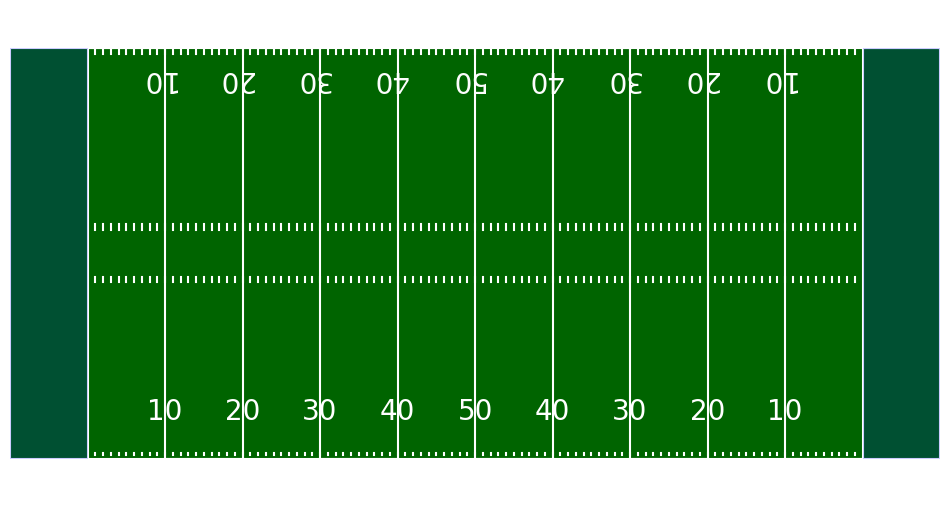

In [76]:
# Calling the plotting function
fig, ax = create_football_field()

# Plotting the figure
plt.show()

In [77]:
tracking.head()

,gamePlayId,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,202209080056,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,202209080056,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,202209080056,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,202209080056,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,202209080056,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


In [78]:
tracking.shape

(12187398, 18)

In [79]:
# Convert into pands Time
tracking["time"] = pd.to_datetime(tracking["time"]).dt.time

tracking.head()

,gamePlayId,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,202209080056,2022090800,56,35472.0,Rodger Saffold,1,20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,202209080056,2022090800,56,35472.0,Rodger Saffold,2,20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,202209080056,2022090800,56,35472.0,Rodger Saffold,3,20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,202209080056,2022090800,56,35472.0,Rodger Saffold,4,20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,202209080056,2022090800,56,35472.0,Rodger Saffold,5,20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


In [80]:
# Sort df by time 

tracking = tracking.sort_values(by = "time", ascending= True).reset_index(drop= True)

tracking.head()

,gamePlayId,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,202210300086,2022103000,86,47824.0,Dalton Risner,1,09:32:23.400000,66.0,DEN,right,30.740000,31.24,0.00,0.00,0.00,87.64,79.49,NaN
1,202210300086,2022103000,86,52481.0,Davon Hamilton,1,09:32:23.400000,52.0,JAX,right,33.510000,29.40,0.20,0.47,0.03,296.85,298.72,NaN
2,202210300086,2022103000,86,43787.0,Roy Robertson-Harris,1,09:32:23.400000,95.0,JAX,right,33.530000,27.07,0.17,0.20,0.02,306.26,272.21,NaN
3,202210300086,2022103000,86,42721.0,Eric Tomlinson,1,09:32:23.400000,87.0,DEN,right,29.950000,34.06,0.04,0.01,0.01,86.92,291.62,NaN
4,202210300086,2022103000,86,NaN,football,1,09:32:23.400000,NaN,football,right,31.860001,30.07,0.03,0.04,0.00,NaN,NaN,NaN


In [81]:
# Pick a game and play 

gamePlayId = 202210300086

tracking_vis = tracking.query("gamePlayId == @gamePlayId")

clubs = tracking_vis['club'].unique()

print("We look at the Game:", clubs[0] ,"vs", clubs[1])

We look at the Game: DEN vs JAX


In [82]:
# Create table with colors
data = {
    "teamName": [
        "Buffalo Bills", "Miami Dolphins", "New England Patriots", "New York Jets",
        "Baltimore Ravens", "Cincinnati Bengals", "Cleveland Browns", "Pittsburgh Steelers",
        "Houston Texans", "Indianapolis Colts", "Jacksonville Jaguars", "Tennessee Titans",
        "Denver Broncos", "Kansas City Chiefs", "Las Vegas Raiders", "Los Angeles Chargers",
        "Dallas Cowboys", "New York Giants", "Philadelphia Eagles", "Washington Commanders",
        "Chicago Bears", "Detroit Lions", "Green Bay Packers", "Minnesota Vikings",
        "Atlanta Falcons", "Carolina Panthers", "New Orleans Saints", "Tampa Bay Buccaneers",
        "Arizona Cardinals", "Los Angeles Rams", "San Francisco 49ers", "Seattle Seahawks"
    ],
    "club": [
        "BUF", "MIA", "NE", "NYJ",
        "BAL", "CIN", "CLE", "PIT",
        "HOU", "IND", "JAX", "TEN",
        "DEN", "KC", "LV", "LAC",
        "DAL", "NYG", "PHI", "WAS",
        "CHI", "DET", "GB", "MIN",
        "ATL", "CAR", "NO", "TB",
        "ARI", "LAR", "SF", "SEA"
    ],
    "color": [
        "#00338D", "#008E97", "#002244", "#125740",
        "#241773", "#FB4F14", "#311D00", "#000000",
        "#03202F", "#002C5F", "#000000", "#002A5C",
        "#FB4F14", "#E31837", "#000000", "#0080C6",
        "#041E42", "#0B2265", "#004953", "#773141",
        "#0B162A", "#0076B6", "#203731", "#4F2683",
        "#000000", "#000000", "#000000", "#D50A0A",
        "#97233F", "#003594", "#AA0000", "#002244"
    ],
    "secondaryColor": [
        "#C60C30", "#FC4C02", "#C8102E", "#FFFFFF",
        "#000000", "#000000", "#FF3C00", "#FFB612",
        "#A71930", "#FFFFFF", "#006778", "#4B92DB",
        "#002244", "#FFB81C", "#A5ACAF", "#FFC20E",
        "#869397", "#A71930", "#A5ACAF", "#FFB612",
        "#C83803", "#B0B7BC", "#FFB612", "#FFC62F",
        "#A71930", "#0085CA", "#D3BC8D", "#34302B",
        "#000000", "#FFA300", "#B3995D", "#69BE28"
    ]
}

# Creating DataFrame
teamColor = pd.DataFrame(data)

# Displaying the DataFrame
teamColor
type(tracking_vis)

tracking_vis = pd.merge(tracking_vis, teamColor, on="club", how="left")

#add football color
tracking_vis["color"] = tracking_vis['color'].fillna('#A52A2A')
tracking_vis["secondaryColor"] = tracking_vis['secondaryColor'].fillna('#FFFFFF')

tracking_vis

,gamePlayId,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,...,y,s,a,dis,o,dir,event,teamName,color,secondaryColor
0,202210300086,2022103000,86,47824.0,Dalton Risner,1,09:32:23.400000,66.0,DEN,right,...,31.24,0.00,0.00,0.00,87.64,79.49,NaN,Denver Broncos,#FB4F14,#002244
1,202210300086,2022103000,86,52481.0,Davon Hamilton,1,09:32:23.400000,52.0,JAX,right,...,29.40,0.20,0.47,0.03,296.85,298.72,NaN,Jacksonville Jaguars,#000000,#006778
2,202210300086,2022103000,86,43787.0,Roy Robertson-Harris,1,09:32:23.400000,95.0,JAX,right,...,27.07,0.17,0.20,0.02,306.26,272.21,NaN,Jacksonville Jaguars,#000000,#006778
3,202210300086,2022103000,86,42721.0,Eric Tomlinson,1,09:32:23.400000,87.0,DEN,right,...,34.06,0.04,0.01,0.01,86.92,291.62,NaN,Denver Broncos,#FB4F14,#002244
4,202210300086,2022103000,86,NaN,football,1,09:32:23.400000,NaN,football,right,...,30.07,0.03,0.04,0.00,NaN,NaN,NaN,NaN,#A52A2A,#FFFFFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,202210300086,2022103000,86,46269.0,Foyesade Oluokun,69,09:32:30.200000,23.0,JAX,right,...,55.41,4.20,1.17,0.43,357.09,342.49,NaN,Jacksonville Jaguars,#000000,#006778
1583,202210300086,2022103000,86,47824.0,Dalton Risner,69,09:32:30.200000,66.0,DEN,right,...,44.12,0.58,0.72,0.06,65.00,17.29,NaN,Denver Broncos,#FB4F14,#002244
1584,202210300086,2022103000,86,53494.0,Andre Cisco,69,09:32:30.200000,5.0,JAX,right,...,53.84,3.05,3.92,0.32,5.34,8.28,NaN,Jacksonville Jaguars,#000000,#006778
1585,202210300086,2022103000,86,52491.0,Lloyd Cushenberry,69,09:32:30.200000,79.0,DEN,right,...,48.50,0.92,1.10,0.10,33.20,336.51,NaN,Denver Broncos,#FB4F14,#002244


In [83]:
#join some info to tracking_vis 

tracking_vis = pd.merge(tracking_vis, plays, on = "gamePlayId", how= "left", suffixes=("","_drop"))

tracking_vis = tracking_vis.loc[:, ~tracking_vis.columns.str.endswith('_drop')]

tracking_vis["color"]

0       #FB4F14
1       #000000
2       #000000
3       #FB4F14
4       #A52A2A
         ...   
1582    #000000
1583    #FB4F14
1584    #000000
1585    #FB4F14
1586    #000000
Name: color, Length: 1587, dtype: object

In [84]:
# Selecting the home and away team

#need to find home team
home_team = tracking_vis.query('club == @clubs[0]')
away_team = tracking_vis.query('club == @clubs[1]')

# Selecting the football
football = tracking_vis.query('club == "football"')

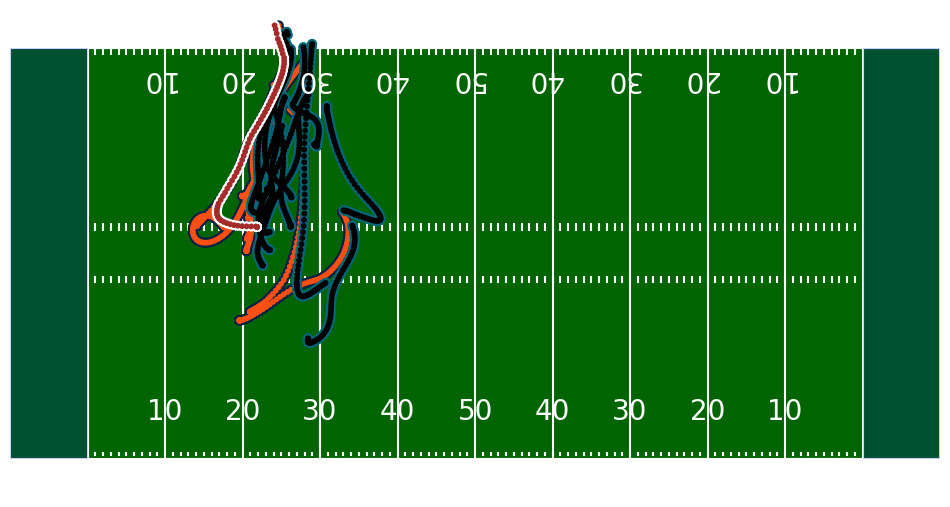

In [85]:
fig, ax = create_football_field()

s1 = 40
s2 = 10

#plot teams
home_team.plot(x='x', y='y', kind='scatter', ax=ax, color=home_team['secondaryColor'], marker = "o", s=s1) 
home_team.plot(x='x', y='y', kind='scatter', ax=ax, color=home_team['color'], marker = "o", s=s2)

away_team.plot(x='x', y='y', kind='scatter', ax=ax, color=away_team['secondaryColor'], marker = "o", s=s1)
away_team.plot(x='x', y='y', kind='scatter', ax=ax, color=away_team['color'], marker = "o", s=s2)

# plot football
football.plot(x='x', y='y', kind='scatter', ax=ax, color=football['secondaryColor'], s=s1)
football.plot(x='x', y='y', kind='scatter', ax=ax, color=football['color'], s=s2)


# Displaying the plot
plt.show()

<a id="animateField"> </a>
## 2. Animate Football Field

<a id="addPredictions"> </a>
## 3. Add the Predictions

In [86]:
#add current time 
#add pred time 
#add actual time 